# Analysis of AirBnB data for Boston, MA and Oakland, CA

This project will analyse listing, availability and review datasets for Airbnb homes in Boston and Oakland using supervised machine learning techniques and data visualisations. The aim of this project is to discover trends in how both hosts and customers use Airbnb, and whether these translate in different areas of the United States. Through this analysis I will answer the following business questions.

### Business Questions and Data Understanding

`1.` What are the most common words used to describe a listing? Are the same words used to describe Boston and Oakland homes?

**To answer this question, we need to use the name, description and neighbourhood_overview columns from the Boston and Oakland listings datasets.**

`2.` How many days a year do homeowners make their homes available to rent? How does this compare between Boston to Oakland?

**The available and date columns from the calendar datasets for both Boston and Oakland will help to answer this question.**

`3.` How much do people charge to rent their homes (on average, minimum, maximum)? How does this compare between Boston to Seattle?

**To answer this question, we need access to the price column of the calendar dataframe for both Boston and Oakland.**

`4.` Are there seasonality components or price spiking components for how hosts set their home prices? How does this compare between Boston to Seattle?

**This question will again use the price column of the calendar dataframe for both Boston and Oakland, and also the date column.**

`5.` Are there any property-specific amenities (i.e. Wi-Fi, TV, kitchen) that can help predict price? Which of these have the strongest influence on price? How does this compare between Boston and Oakland? 

**For this question, we will need to look at the amenities column of the listings datasets for Boston and Oakland. Given that price will be highly correlated to property type (entire home or private room) and number of bedrooms and bathrooms the analysis will be grouped by these features.**

`6.` How many reviews do homes tend to get? What are common words used in reviews and are they primarily positive or negative? How does this compare between Boston to Oakland?

**The comments column from the reviews datasets for both Boston and Oakland will help answer this question. We will also need to look at the home_id value to identify the reviews belonging to each unique home.**

### Data Preparation

For each of the business questions outlined above, I will break the data preparation, data analysis and results into its own section.

In order to get a better understanding of the data we will be looking at throughout this analysis, let's take a look at some of the characteristics of the dataset.

First, let's read in the necessary libraries and datasets.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string
from collections import Counter
import operator
from nltk.corpus import stopwords
import spacy
import en_core_web_sm
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud
from textblob import TextBlob
import scattertext as st
from scattertext import produce_scattertext_explorer
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

%matplotlib inline

# Import Boston data
calendar_boston = pd.read_csv('./calendar_boston.csv')
listings_boston = pd.read_csv('./listings_boston.csv')
reviews_boston = pd.read_csv('./reviews_boston.csv')

# Import Oakland data
calendar_oakland = pd.read_csv('./calendar_oakland.csv')
listings_oakland = pd.read_csv('./listings_oakland.csv')
reviews_oakland = pd.read_csv('./reviews_oakland.csv')

Next let's determine the number of listings and reviews for Boston and Oakland.

In [2]:
# Determine number of listings and reviews for Boston and Oakland
print("There are", len(listings_boston), "properties listed in Boston")
print("There have been", len(reviews_boston), "reviews posted for properties in Boston between", min(reviews_boston.date), "and", max(reviews_boston.date))
print("There are", len(listings_oakland), "properties listed in Oakland")
print("There have been", len(reviews_oakland), "reviews posted for properties in Oakland between", min(reviews_oakland.date), "and", max(reviews_oakland.date))

There are 3106 properties listed in Boston
There have been 117541 reviews posted for properties in Boston between 2009-08-06 and 2020-12-20
There are 2301 properties listed in Oakland
There have been 86819 reviews posted for properties in Oakland between 2009-07-14 and 2020-12-31


Examine the number of rows and columns in each dataset, as well as the type of features available for the analysis.

In [3]:
# Calculate the number of rows and columns in each dataset
print('Boston datasets:\n')
print('calendar_boston: rows:', calendar_boston.shape[0], '; columns:', calendar_boston.shape[1])
print('listings_boston: rows:', listings_boston.shape[0], '; columns:', listings_boston.shape[1])
print('reviews_boston: rows:', reviews_boston.shape[0], '; columns:', reviews_boston.shape[1])
print('Oakland datasets:\n')
print('calendar_oakland: rows:', calendar_oakland.shape[0], '; columns:', calendar_oakland.shape[1])
print('listings_oakland: rows:', listings_oakland.shape[0], '; columns:', listings_oakland.shape[1])
print('reviews_oakland: rows:', reviews_oakland.shape[0], '; columns:', reviews_oakland.shape[1])

Boston datasets:

calendar_boston: rows: 1133325 ; columns: 7
listings_boston: rows: 3106 ; columns: 74
reviews_boston: rows: 117541 ; columns: 6
Oakland datasets:

calendar_oakland: rows: 839979 ; columns: 7
listings_oakland: rows: 2301 ; columns: 74
reviews_oakland: rows: 86819 ; columns: 6


In [4]:
# Boston and Oakland calendar data features
print('Boston calendar dataset:\n')
calendar_boston.info(verbose=True)
print('\n')
print('Oakland calendar dataset:\n')
calendar_oakland.info(verbose=True)

Boston calendar dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133325 entries, 0 to 1133324
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   listing_id      1133325 non-null  int64 
 1   date            1133325 non-null  object
 2   available       1133325 non-null  object
 3   price           1133325 non-null  object
 4   adjusted_price  1133325 non-null  object
 5   minimum_nights  1133325 non-null  int64 
 6   maximum_nights  1133325 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 60.5+ MB


Oakland calendar dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839979 entries, 0 to 839978
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   listing_id      839979 non-null  int64  
 1   date            839979 non-null  object 
 2   available       839979 non-null  object 
 3   price           839979 

In [5]:
# Boston and Oakland listings data features
print('Boston listings dataset:\n')
listings_boston.info(verbose=True)
print('\n')
print('Oakland listings dataset:\n')
listings_oakland.info(verbose=True)

Boston listings dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3106 entries, 0 to 3105
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3106 non-null   int64  
 1   listing_url                                   3106 non-null   object 
 2   scrape_id                                     3106 non-null   int64  
 3   last_scraped                                  3106 non-null   object 
 4   name                                          3106 non-null   object 
 5   description                                   3073 non-null   object 
 6   neighborhood_overview                         2195 non-null   object 
 7   picture_url                                   3106 non-null   object 
 8   host_id                                       3106 non-null   int64  
 9   host_url                             

In [6]:
# Boston and Oakland reviews data features
print('Boston reviews dataset:\n')
reviews_boston.info(verbose=True)
print('\n')
print('Oakland reviews dataset:\n')
reviews_oakland.info(verbose=True)

Boston reviews dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117541 entries, 0 to 117540
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     117541 non-null  int64 
 1   id             117541 non-null  int64 
 2   date           117541 non-null  object
 3   reviewer_id    117541 non-null  int64 
 4   reviewer_name  117540 non-null  object
 5   comments       117467 non-null  object
dtypes: int64(3), object(3)
memory usage: 5.4+ MB


Oakland reviews dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86819 entries, 0 to 86818
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     86819 non-null  int64 
 1   id             86819 non-null  int64 
 2   date           86819 non-null  object
 3   reviewer_id    86819 non-null  int64 
 4   reviewer_name  86819 non-null  object
 5   comments       86762 

### Data Analysis and Evaluation

**`1.` What are the most common words used to describe a listing? Are the same words used to describe Boston and Oakland homes?**

Let's take a closer look at the wording used in the names, descriptions and neighbourhood overviews of the listings to try to ascertain whether there are any trends, similarities or differences between the listings or between Boston and Oakland. We will need to clean that data.

In [7]:
# Merge all names, descriptions and neighbourhood overviews into a single string for each city
all_names_boston = ', '.join(str(name) for name in list(listings_boston['name']))
all_descriptions_boston = ', '.join(str(desc) for desc in list(listings_boston['description']))
all_neighborhood_boston = ', '.join(str(neighbour) for neighbour in list(listings_boston['neighborhood_overview']))

all_names_oakland = ', '.join(str(name) for name in list(listings_oakland['name']))
all_descriptions_oakland = ', '.join(str(desc) for desc in list(listings_oakland['description']))
all_neighborhood_oakland = ', '.join(str(neighbour) for neighbour in list(listings_oakland['neighborhood_overview']))

In [8]:
# Combine name, description and neighbourhood overview strings for each city
all_listing_words_boston = all_names_boston + all_descriptions_boston + all_neighborhood_boston
all_listing_words_oakland = all_names_oakland + all_descriptions_oakland + all_neighborhood_oakland

In [9]:
# Define a function to clean the text data and count occurance
# Returns a list of tuples containing the description word and occurance count in ascending order
def clean_desc_text(all_listing_words):
    
    # Create a list of stop words and remove from list of words
    stop_words = set(stopwords.words('english'))
    words = filter(lambda word: not word in stop_words, all_listing_words.lower().split())
    
    # Remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in words]
    
    # Count each occurance and sort list of words alphabetically
    word_count = Counter(stripped)
    sorted_word_count = sorted(word_count.items(), key=operator.itemgetter(1))
    
    return sorted_word_count

In [10]:
# Apply cleaning function to combined strings
sorted_listing_words_boston = clean_desc_text(all_listing_words_boston)
sorted_listing_words_oakland = clean_desc_text(all_listing_words_oakland)

In [11]:
# List of top 25 words used to describe Boston listings
boston_listing_top_words = sorted(sorted_listing_words_boston, key=operator.itemgetter(1), reverse=True)[:25]
boston_listing_top_words

[('br', 12941),
 ('', 8585),
 ('boston', 7052),
 ('room', 3413),
 ('apartment', 3358),
 ('walk', 2676),
 ('kitchen', 2510),
 ('bthe', 2475),
 ('spacebbr', 2475),
 ('neighborhood', 2078),
 ('home', 2002),
 ('street', 1982),
 ('bedroom', 1978),
 ('located', 1942),
 ('downtown', 1915),
 ('private', 1802),
 ('restaurants', 1782),
 ('one', 1770),
 ('house', 1734),
 ('bed', 1621),
 ('living', 1592),
 ('2', 1554),
 ('away', 1423),
 ('minutes', 1383),
 ('bathroom', 1364)]

In [12]:
# List of top 25 words used to describe Oakland listings
oakland_listing_top_words = sorted(sorted_listing_words_oakland, key=operator.itemgetter(1), reverse=True)[:25]
oakland_listing_top_words

[('br', 7816),
 ('', 4925),
 ('oakland', 3310),
 ('home', 2740),
 ('room', 2617),
 ('apartment', 2243),
 ('bthe', 1858),
 ('spacebbr', 1858),
 ('private', 1770),
 ('kitchen', 1760),
 ('bedroom', 1750),
 ('bart', 1522),
 ('neighborhood', 1504),
 ('house', 1502),
 ('away', 1393),
 ('area', 1347),
 ('san', 1275),
 ('bathroom', 1257),
 ('stay', 1238),
 ('beautiful', 1223),
 ('bay', 1178),
 ('restaurants', 1129),
 ('bed', 1126),
 ('also', 1124),
 ('walk', 1119)]

In [13]:
# In order to compare, create a list of the top 100 words used to describe listings in Boston and Oakland
boston_listing_100_words = []
for tup in sorted(sorted_listing_words_boston, key=operator.itemgetter(1), reverse=True)[:100]:
    boston_listing_100_words.append(tup[0])

oakland_listing_100_words = []
for tup in sorted(sorted_listing_words_oakland, key=operator.itemgetter(1), reverse=True)[:100]:
    oakland_listing_100_words.append(tup[0])

In [14]:
# Create functions to determine the intersection and differences between the top 100 words used to describe listings in Boston and Oakland
def top_desc_words_intersection(list_1, list_2): 
    list_3 = [word for word in list_1 if word in list_2] 
    return list_3

def top_desc_words_difference(list_1, list_2):
    list_3 = [word for word in list_1 if word not in list_2] 
    return list_3

In [15]:
# What words are common between listing descriptions in Boston and Oakland
common_listing_words = top_desc_words_intersection(boston_listing_100_words, oakland_listing_100_words)
common_listing_words

['br',
 '',
 'room',
 'apartment',
 'walk',
 'kitchen',
 'bthe',
 'spacebbr',
 'neighborhood',
 'home',
 'street',
 'bedroom',
 'located',
 'downtown',
 'private',
 'restaurants',
 'one',
 'house',
 'bed',
 'living',
 '2',
 'away',
 'minutes',
 'bathroom',
 'area',
 'also',
 'stay',
 'close',
 'access',
 'bay',
 'great',
 'beautiful',
 'station',
 'guests',
 'space',
 '1',
 'park',
 'unit',
 'walking',
 'full',
 'parking',
 'minute',
 'easy',
 '3',
 'the',
 'place',
 'nan',
 'large',
 'two',
 'studio',
 'distance',
 'quiet',
 'new',
 'queen',
 '5',
 'please',
 'bguest',
 'accessbbr',
 'fully',
 'you’ll',
 'clean',
 'enjoy',
 'comfortable',
 'shops',
 'spacious',
 'shared',
 'coffee',
 '10']

In [16]:
# What words are unique to Boston listing descriptions when compared to Oakland listing descriptions
boston_unique_listing_words = top_desc_words_difference(boston_listing_100_words, oakland_listing_100_words)
boston_unique_listing_words

['boston',
 'south',
 'floor',
 'city',
 'line',
 'back',
 'end',
 'public',
 'furnished',
 'center',
 'building',
 'hill',
 'location',
 'historic',
 'common',
 'near',
 'min',
 'modern',
 'free',
 'tv',
 'many',
 'size',
 'renovated',
 'within',
 'north',
 'square',
 'available',
 'district',
 'harvard',
 'subway',
 'well',
 'this']

In [17]:
# What words are unique to Oakland listing descriptions when compared to Boston listing descriptions
oakland_unique_listing_words = top_desc_words_difference(oakland_listing_100_words, boston_listing_100_words)
oakland_unique_listing_words

['oakland',
 'bart',
 'san',
 'lake',
 'francisco',
 'cleaning',
 'we',
 'nights',
 'cdc',
 'guidance',
 'berkeley',
 'merritt',
 'take',
 'entire',
 'door',
 'sf',
 'blocks',
 'cozy',
 'property',
 'garden',
 'things',
 'note',
 'etc',
 'temescal',
 'drive',
 'provided',
 'set',
 'rockridge',
 '30',
 'stays',
 'booking',
 'bath']

In [18]:
# Create a visualisation of the most common words used in the description of listings in Boston and Oakland
# First create a dataframe containing all listing descriptions and add a field identifying the city
listing_descs_boston = listings_boston[['description']]
listing_descs_oakland = listings_oakland[['description']]
listing_descs_boston['city'] = 'Boston'
listing_descs_oakland['city'] = 'Oakland'
frames = [listing_descs_boston, listing_descs_oakland]
listing_descs = pd.concat(frames, ignore_index=True)
listing_descs

description     city
0     Fully separate apartment in a two apartment bu...   Boston
1     Comfortable,  Fully Equipped private apartment...   Boston
2     Stunning Back Bay furnished studio apartment. ...   Boston
3     Chic furnished studio apartment is located on ...   Boston
4     Beautiful studio apartment in a great Back Bay...   Boston
...                                                 ...      ...
5402                                                NaN  Oakland
5403  Welcome to our large, newly renovated guest ho...  Oakland
5404  This new 3 bedrooms 2 bathroom house is equipp...  Oakland
5405  This is a two bedroom and one bath. The house ...  Oakland
5406                                                NaN  Oakland

[5407 rows x 2 columns]

In [19]:
# Clean the dataframe of any NaN values and replace with empty strings
listing_descs = listing_descs.fillna('')

In [20]:
# Use SpaCy to parse the descriptions
nlp = en_core_web_sm.load()

listing_descs['parsed'] = listing_descs.description.apply(nlp)
listing_descs

description     city  \
0     Fully separate apartment in a two apartment bu...   Boston   
1     Comfortable,  Fully Equipped private apartment...   Boston   
2     Stunning Back Bay furnished studio apartment. ...   Boston   
3     Chic furnished studio apartment is located on ...   Boston   
4     Beautiful studio apartment in a great Back Bay...   Boston   
...                                                 ...      ...   
5402                                                     Oakland   
5403  Welcome to our large, newly renovated guest ho...  Oakland   
5404  This new 3 bedrooms 2 bathroom house is equipp...  Oakland   
5405  This is a two bedroom and one bath. The house ...  Oakland   
5406                                                     Oakland   

                                                 parsed  
0     (Fully, separate, apartment, in, a, two, apart...  
1     (Comfortable, ,,  , Fully, Equipped, private, ...  
2     (Stunning, Back, Bay, furnished, studio, apart...  
3     (Chic, furnished, studio, apartment, is, locat...  
4     (Beautiful, studio, apartment, in, a, great, B...  
...                                                 ...  
5402                                                 ()  
5403  (Welcome, to, our, large, ,, newly, renovated,...  
5404  (This, new, 3, bedrooms, 2, bathroom, house, i...  
5405  (This, is, a, two, bedroom, and, one, bath, .,...  
5406                                                 ()  

[5407 rows x 3 columns]

In [21]:
# Clean the parsed descriptions of punctuation and create a column with the cleaned descriptions
clean_parsed_desc = []
for i in range(0, listing_descs.shape[0]):
    parsed_desc = listing_descs['parsed'][i]
    list_parsed_desc = list(parsed_desc)
    str_parsed_desc = []
    for word in list_parsed_desc:
        str_parsed_desc.append(str(word))
    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in str_parsed_desc]
    clean_parsed_desc.append(stripped)
    
listing_descs['description_clean'] = clean_parsed_desc
listing_descs

description     city  \
0     Fully separate apartment in a two apartment bu...   Boston   
1     Comfortable,  Fully Equipped private apartment...   Boston   
2     Stunning Back Bay furnished studio apartment. ...   Boston   
3     Chic furnished studio apartment is located on ...   Boston   
4     Beautiful studio apartment in a great Back Bay...   Boston   
...                                                 ...      ...   
5402                                                     Oakland   
5403  Welcome to our large, newly renovated guest ho...  Oakland   
5404  This new 3 bedrooms 2 bathroom house is equipp...  Oakland   
5405  This is a two bedroom and one bath. The house ...  Oakland   
5406                                                     Oakland   

                                                 parsed  \
0     (Fully, separate, apartment, in, a, two, apart...   
1     (Comfortable, ,,  , Fully, Equipped, private, ...   
2     (Stunning, Back, Bay, furnished, studio, apart...   
3     (Chic, furnished, studio, apartment, is, locat...   
4     (Beautiful, studio, apartment, in, a, great, B...   
...                                                 ...   
5402                                                 ()   
5403  (Welcome, to, our, large, ,, newly, renovated,...   
5404  (This, new, 3, bedrooms, 2, bathroom, house, i...   
5405  (This, is, a, two, bedroom, and, one, bath, .,...   
5406                                                 ()   

                                      description_clean  
0     [Fully, separate, apartment, in, a, two, apart...  
1     [Comfortable, ,  , Fully, Equipped, private, a...  
2     [Stunning, Back, Bay, furnished, studio, apart...  
3     [Chic, furnished, studio, apartment, is, locat...  
4     [Beautiful, studio, apartment, in, a, great, B...  
...                                                 ...  
5402                                                 []  
5403  [Welcome, to, our, large, , newly, renovated, ...  
5404  [This, new, 3, bedrooms, 2, bathroom, house, i...  
5405  [This, is, a, two, bedroom, and, one, bath, , ...  
5406                                                 []  

[5407 rows x 4 columns]

In [22]:
# Concatenate the individual description strings into one
for i in range(0, listing_descs.shape[0]):
    listing_descs['description_clean'][i] = " ".join(listing_descs['description_clean'][i])
listing_descs

description     city  \
0     Fully separate apartment in a two apartment bu...   Boston   
1     Comfortable,  Fully Equipped private apartment...   Boston   
2     Stunning Back Bay furnished studio apartment. ...   Boston   
3     Chic furnished studio apartment is located on ...   Boston   
4     Beautiful studio apartment in a great Back Bay...   Boston   
...                                                 ...      ...   
5402                                                     Oakland   
5403  Welcome to our large, newly renovated guest ho...  Oakland   
5404  This new 3 bedrooms 2 bathroom house is equipp...  Oakland   
5405  This is a two bedroom and one bath. The house ...  Oakland   
5406                                                     Oakland   

                                                 parsed  \
0     (Fully, separate, apartment, in, a, two, apart...   
1     (Comfortable, ,,  , Fully, Equipped, private, ...   
2     (Stunning, Back, Bay, furnished, studio, apart...   
3     (Chic, furnished, studio, apartment, is, locat...   
4     (Beautiful, studio, apartment, in, a, great, B...   
...                                                 ...   
5402                                                 ()   
5403  (Welcome, to, our, large, ,, newly, renovated,...   
5404  (This, new, 3, bedrooms, 2, bathroom, house, i...   
5405  (This, is, a, two, bedroom, and, one, bath, .,...   
5406                                                 ()   

                                      description_clean  
0     Fully separate apartment in a two apartment bu...  
1     Comfortable    Fully Equipped private apartmen...  
2     Stunning Back Bay furnished studio apartment  ...  
3     Chic furnished studio apartment is located on ...  
4     Beautiful studio apartment in a great Back Bay...  
...                                                 ...  
5402                                                     
5403  Welcome to our large  newly renovated guest ho...  
5404  This new 3 bedrooms 2 bathroom house is equipp...  
5405  This is a two bedroom and one bath  The house ...  
5406                                                     

[5407 rows x 4 columns]

In [23]:
# Parse the cleaned descriptions
listing_descs['parsed_clean'] = listing_descs.description_clean.apply(nlp)
listing_descs

description     city  \
0     Fully separate apartment in a two apartment bu...   Boston   
1     Comfortable,  Fully Equipped private apartment...   Boston   
2     Stunning Back Bay furnished studio apartment. ...   Boston   
3     Chic furnished studio apartment is located on ...   Boston   
4     Beautiful studio apartment in a great Back Bay...   Boston   
...                                                 ...      ...   
5402                                                     Oakland   
5403  Welcome to our large, newly renovated guest ho...  Oakland   
5404  This new 3 bedrooms 2 bathroom house is equipp...  Oakland   
5405  This is a two bedroom and one bath. The house ...  Oakland   
5406                                                     Oakland   

                                                 parsed  \
0     (Fully, separate, apartment, in, a, two, apart...   
1     (Comfortable, ,,  , Fully, Equipped, private, ...   
2     (Stunning, Back, Bay, furnished, studio, apart...   
3     (Chic, furnished, studio, apartment, is, locat...   
4     (Beautiful, studio, apartment, in, a, great, B...   
...                                                 ...   
5402                                                 ()   
5403  (Welcome, to, our, large, ,, newly, renovated,...   
5404  (This, new, 3, bedrooms, 2, bathroom, house, i...   
5405  (This, is, a, two, bedroom, and, one, bath, .,...   
5406                                                 ()   

                                      description_clean  \
0     Fully separate apartment in a two apartment bu...   
1     Comfortable    Fully Equipped private apartmen...   
2     Stunning Back Bay furnished studio apartment  ...   
3     Chic furnished studio apartment is located on ...   
4     Beautiful studio apartment in a great Back Bay...   
...                                                 ...   
5402                                                      
5403  Welcome to our large  newly renovated guest ho...   
5404  This new 3 bedrooms 2 bathroom house is equipp...   
5405  This is a two bedroom and one bath  The house ...   
5406                                                      

                                           parsed_clean  
0     (Fully, separate, apartment, in, a, two, apart...  
1     (Comfortable,    , Fully, Equipped, private, a...  
2     (Stunning, Back, Bay, furnished, studio, apart...  
3     (Chic, furnished, studio, apartment, is, locat...  
4     (Beautiful, studio, apartment, in, a, great, B...  
...                                                 ...  
5402                                                 ()  
5403  (Welcome, to, our, large,  , newly, renovated,...  
5404  (This, new, 3, bedrooms, 2, bathroom, house, i...  
5405  (This, is, a, two, bedroom, and, one, bath,  ,...  
5406                                                 ()  

[5407 rows x 5 columns]

In [24]:
# Compare the original and cleaned descriptions to ensure all punctuation has been removed
listing_descs['parsed'][0]

Fully separate apartment in a two apartment building. Space is perfect for an individual or a couple. There is a full bath, bedroom with queen bed, small sitting area with TV and a fully equipped kitchen with dining area. Walk or bus to subway.<br /><br /><b>The space</b><br />This is a totally separate apartment located on the first floor of a 3 story building. Apartment has one bedroom with queen sized bed plus full eat-in kitchen,sitting room and full bath with tub/shower. Free off street parking for one car. SORRY NO SNOW REMOVAL SERVICE FOR CAR.  Free wi-fi <br /><br />10 minute walk/5 minute bus (3 doors away) to subway station--next stop is Aquarium/Faneuil Hall in central Boston. <br /><br />Guests who have stayed in our apartment have used it as a home base to explore Boston and surroundings. Others during extended stays at the apartment have commuted to  Massachusetts General Hospital (MGH) and Massachusetts Institute of Technology (MIT).  <br /><br />The harbor and harbor wa

In [25]:
listing_descs['parsed_clean'][0]

Fully separate apartment in a two apartment building  Space is perfect for an individual or a couple  There is a full bath  bedroom with queen bed  small sitting area with TV and a fully equipped kitchen with dining area  Walk or bus to subwaybr br b  The spacebbr This is a totally separate apartment located on the first floor of a 3 story building  Apartment has one bedroom with queen sized bed plus full eat  in kitchen  sitting room and full bath with tub  shower  Free off street parking for one car  SORRY NO SNOW REMOVAL SERVICE FOR CAR    Free wi  fi  br br 10 minute walk5 minute bus  3 doors away  to subway station  next stop is Aquarium  Faneuil Hall in central Boston   br br Guests who have stayed in our apartment have used it as a home base to explore Boston and surroundings  Others during extended stays at the apartment have commuted to   Massachusetts General Hospital  MGH  and Massachusetts Institute of Technology  MIT      br br The harbor and harbor wa

In [26]:
# Build corpus for visualisation
corpus_desc = st.CorpusFromParsedDocuments(
    listing_descs, category_col='city', parsed_col='parsed_clean'
).build()

In [27]:
# Remove stop words
corpus_desc.remove_terms(set(stopwords.words('english')), ignore_absences=True)

In [28]:
# Remove any remaining punctuation
corpus_desc.remove_terms(list(string.punctuation), ignore_absences=True)

In [29]:
# Produce visualisation using scattertext
# The visualisation will display in the output cell but an interactive version will be saved as an html file in the project directory
# Open the html file in the browser to see full functionality
html_desc = st.produce_scattertext_explorer(
    corpus_desc,
    category='Boston',
    category_name='Boston',
    not_category_name='Oakland',
    minimum_term_frequency=50,
    width_in_pixels=1000,
    #transform=st.Scalers.log_scale_standardize
    term_significance = st.LogOddsRatioUninformativeDirichletPrior()
)
file_name = 'AirBnB_listing_desc_words.html'
open(file_name, 'wb').write(html_desc.encode('utf-8'))
display(HTML(filename=file_name))

**`2.` How many days a year do homeowners make their homes available to rent? How does this compare between Boston and Oakland?**

Let's use the date and available fields from the calendar dataset to determine the dates that properties are listed as available. We will also use the room_type field from the listings dataset in order to distinguish between private rooms and entire properties.

In [30]:
# First check for missing values in the date and available fields within the calendar datasets
print('Boston calendar dataset missing values\n')
print(calendar_boston.isnull().sum())
print('\n')
print('Oakland calendar dataset missing values\n')
print(calendar_oakland.isnull().sum())

Boston calendar dataset missing values

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64


Oakland calendar dataset missing values

listing_id          0
date                0
available           0
price               0
adjusted_price      0
minimum_nights    116
maximum_nights    116
dtype: int64


In [31]:
# Change available field to a boolean
calendar_boston.available.replace('f', False, inplace=True)
calendar_boston.available.replace('t', True, inplace=True)
calendar_oakland.available.replace('f', False, inplace=True)
calendar_oakland.available.replace('t', True, inplace=True)

calendar_boston.head()

listing_id        date  available    price adjusted_price  minimum_nights  \
0     1109224  2020-12-21      False  $439.00        $439.00               2   
1     1109224  2020-12-22       True  $439.00        $439.00               2   
2     1109224  2020-12-23       True  $439.00        $439.00               2   
3     1109224  2020-12-24       True  $439.00        $439.00               2   
4     1109224  2020-12-25       True  $469.00        $469.00               2   

   maximum_nights  
0              90  
1              90  
2              90  
3              90  
4              90

In [32]:
# For each listing determine the proportion of dates that the property is available
listing_availability_boston = calendar_boston.groupby('listing_id').mean()['available'].reset_index()
listing_availability_boston.columns = ['listing_id', 'prop_available']
listing_availability_boston['prop_occupied'] = 1 - listing_availability_boston['prop_available']

listing_availability_oakland = calendar_oakland.groupby('listing_id').mean()['available'].reset_index()
listing_availability_oakland.columns = ['listing_id', 'prop_available']
listing_availability_oakland['prop_occupied'] = 1 - listing_availability_oakland['prop_available']

listing_availability_boston.head()

listing_id  prop_available  prop_occupied
0        3781        0.693151       0.306849
1        6695        0.000000       1.000000
2       10813        0.997260       0.002740
3       10986        0.997260       0.002740
4       13247        0.000000       1.000000

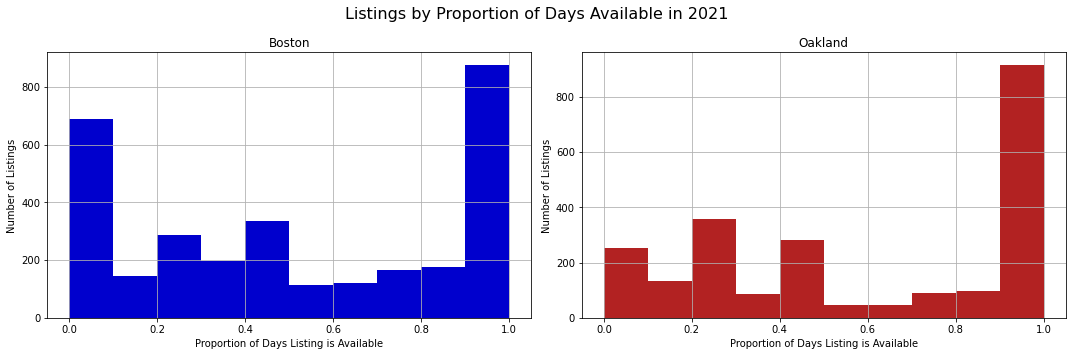

In [33]:
# Create a visualisation comparing listings availability in Boston and Oakland
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Listings by Proportion of Days Available in 2021', fontsize=16)

listing_availability_boston.prop_available.hist(color="mediumblue", ax=ax[0]);
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Number of Listings');
ax[0].set_xlabel('Proportion of Days Listing is Available');

listing_availability_oakland.prop_available.hist(color="firebrick", ax=ax[1]);
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Number of Listings');
ax[1].set_xlabel('Proportion of Days Listing is Available');

plt.tight_layout()

In [34]:
# Print statistics for listings availability in Boston and Oakland
print("Boston listings availability statistics\n")
print(listing_availability_boston.prop_available.describe())
print("\n")
print("Oakland listings availability statistics\n")
print(listing_availability_oakland.prop_available.describe())

Boston listings availability statistics

count    3105.000000
mean        0.514336
std         0.378849
min         0.000000
25%         0.161644
50%         0.490411
75%         0.942466
max         1.000000
Name: prop_available, dtype: float64


Oakland listings availability statistics

count    2301.000000
mean        0.596272
std         0.366498
min         0.000000
25%         0.243836
50%         0.589041
75%         0.983562
max         1.000000
Name: prop_available, dtype: float64


From the plots it appears that a significant proportion of listings in Oakland are available to rent more than 90% of the year. Listings in Boston follow a similar trend, however, there are significantly more homes (nearly a third) that are only available to rent less than 10% of the year implying that a greater proportion of listings in Boston are the primary residences of the hosts.

In order to identify the actual proportion of listings that are essentially just rentals, we need to consider the property type - specifically whether it is a private room within the host's home or the entire home itself.

In [35]:
# First check that there are no missing values in the room_type field
print('Boston - number of missing values in room_type field:', listings_boston.room_type.isnull().sum())
print('Oakland - number of missing values in room_type field:', listings_oakland.room_type.isnull().sum())

Boston - number of missing values in room_type field: 0
Oakland - number of missing values in room_type field: 0


In [36]:
# Check unique entries in room_type field for Boston
listings_boston.room_type.value_counts()

Entire home/apt    1984
Private room       1085
Hotel room           26
Shared room          11
Name: room_type, dtype: int64

In [37]:
# Check unique entries in room_type field for Oakland
listings_oakland.room_type.value_counts()

Entire home/apt    1549
Private room        655
Shared room          96
Hotel room            1
Name: room_type, dtype: int64

Given that there are very few hotel rooms and shared rooms, we will only look at the availability of private rooms and entire homes.

In [38]:
# Create a dataframe for each listing type and determine the proportion of dates that each property is available

# Private rooms - Boston
list_boston_room = listings_boston[listings_boston['room_type'] == 'Private room']['id'].to_list()
calendar_boston_room = calendar_boston[calendar_boston['listing_id'].isin(list_boston_room)]
listing_availability_boston_room = calendar_boston_room.groupby('listing_id').mean()['available'].reset_index()
listing_availability_boston_room.columns = ['listing_id', 'prop_available']
listing_availability_boston_room['prop_occupied'] = 1 - listing_availability_boston_room['prop_available']

# Private rooms - Oakland
list_oakland_room = listings_oakland[listings_oakland['room_type'] == 'Private room']['id'].to_list()
calendar_oakland_room = calendar_oakland[calendar_oakland['listing_id'].isin(list_oakland_room)]
listing_availability_oakland_room = calendar_oakland_room.groupby('listing_id').mean()['available'].reset_index()
listing_availability_oakland_room.columns = ['listing_id', 'prop_available']
listing_availability_oakland_room['prop_occupied'] = 1 - listing_availability_oakland_room['prop_available']

# Entire home - Boston
list_boston_home = listings_boston[listings_boston['room_type'] == 'Entire home/apt']['id'].to_list()
calendar_boston_home = calendar_boston[calendar_boston['listing_id'].isin(list_boston_home)]
listing_availability_boston_home = calendar_boston_home.groupby('listing_id').mean()['available'].reset_index()
listing_availability_boston_home.columns = ['listing_id', 'prop_available']
listing_availability_boston_home['prop_occupied'] = 1 - listing_availability_boston_home['prop_available']

# Entire home - Oakland
list_oakland_home = listings_oakland[listings_oakland['room_type'] == 'Entire home/apt']['id'].to_list()
calendar_oakland_home = calendar_oakland[calendar_oakland['listing_id'].isin(list_oakland_home)]
listing_availability_oakland_home = calendar_oakland_home.groupby('listing_id').mean()['available'].reset_index()
listing_availability_oakland_home.columns = ['listing_id', 'prop_available']
listing_availability_oakland_home['prop_occupied'] = 1 - listing_availability_oakland_home['prop_available']

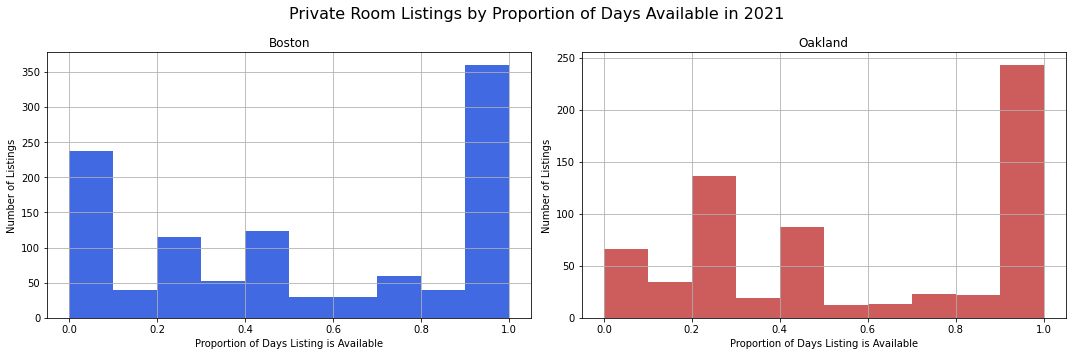

In [39]:
# Create a visualisation comparing private room listings availability in Boston and Oakland
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Private Room Listings by Proportion of Days Available in 2021', fontsize=16)

listing_availability_boston_room.prop_available.hist(color="royalblue", ax=ax[0]);
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Number of Listings');
ax[0].set_xlabel('Proportion of Days Listing is Available');

listing_availability_oakland_room.prop_available.hist(color="indianred", ax=ax[1]);
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Number of Listings');
ax[1].set_xlabel('Proportion of Days Listing is Available');

plt.tight_layout();

In [40]:
# Print statistics for private room listings availability in Boston and Oakland
print("Boston private room listings availability statistics\n")
print(listing_availability_boston_room.prop_available.describe())
print("\n")
print("Oakland private room listings availability statistics\n")
print(listing_availability_oakland_room.prop_available.describe())

Boston private room listings availability statistics

count    1085.000000
mean        0.532812
std         0.391069
min         0.000000
25%         0.175342
50%         0.493151
75%         0.978082
max         1.000000
Name: prop_available, dtype: float64


Oakland private room listings availability statistics

count    655.000000
mean       0.574488
std        0.365671
min        0.000000
25%        0.243169
50%        0.490411
75%        0.991792
max        1.000000
Name: prop_available, dtype: float64


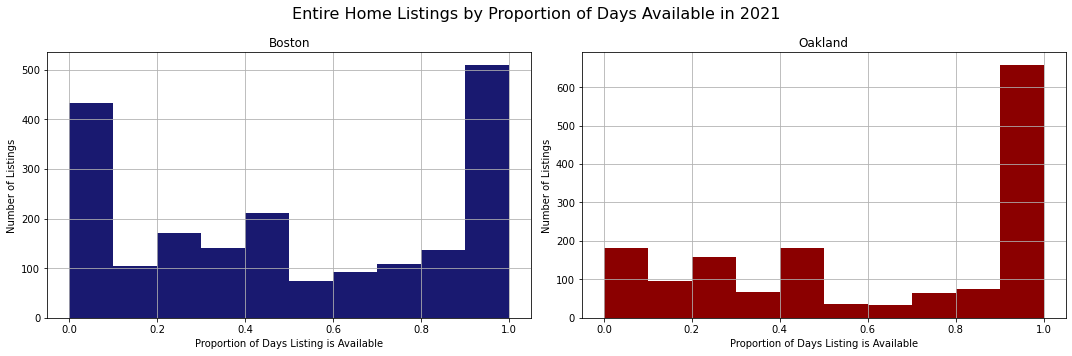

In [41]:
# Create a visualisation comparing entire home listings availability in Boston and Oakland
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Entire Home Listings by Proportion of Days Available in 2021', fontsize=16)

listing_availability_boston_home.prop_available.hist(color="midnightblue", ax=ax[0]);
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Number of Listings');
ax[0].set_xlabel('Proportion of Days Listing is Available');

listing_availability_oakland_home.prop_available.hist(color="darkred", ax=ax[1]);
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Number of Listings');
ax[1].set_xlabel('Proportion of Days Listing is Available');

plt.tight_layout();

In [42]:
# Print statistics for entire home listings availability in Boston and Oakland
print("Boston entire home listings availability statistics\n")
print(listing_availability_boston_home.prop_available.describe())
print("\n")
print("Oakland entire home listings availability statistics\n")
print(listing_availability_oakland_home.prop_available.describe())

Boston entire home listings availability statistics

count    1984.000000
mean        0.507224
std         0.371545
min         0.000000
25%         0.161644
50%         0.487671
75%         0.912329
max         1.000000
Name: prop_available, dtype: float64


Oakland entire home listings availability statistics

count    1549.000000
mean        0.620377
std         0.366015
min         0.000000
25%         0.243836
50%         0.734247
75%         0.983562
max         1.000000
Name: prop_available, dtype: float64


From the revised plots it is clear that just over 40% of entire homes / apartments listed for rent on AirBnB in Oakland are essentially just rentals where the host spends very little to no time in the home. The proportion in Boston is lower, at just over 25%, but it is also evident that just over 20% of entire homes / apartments listed are only available less than 10% of the time. When combined with the fact that 35% of Boston listings are private rooms, compared with less than 30% for Oakland, it is clear that the way people use their homes for rentals in Boston is different to Oakland.

Next, let's consider how the proportion of listings available within these two cities varies throughout the year.

In [43]:
# Determine the proportion of available listings for Boston and Oakland for each day in the calendar datasets
listing_availability_boston_daily = calendar_boston.groupby('date').mean()['available'].reset_index()
listing_availability_oakland_daily = calendar_oakland.groupby('date').mean()['available'].reset_index()

# Determine the proportion of available private room listings for Boston and Oakland for each day in the calendar datasets
listing_availability_boston_daily_room = calendar_boston_room.groupby('date').mean()['available'].reset_index()
listing_availability_oakland_daily_room = calendar_oakland_room.groupby('date').mean()['available'].reset_index()

# Determine the proportion of available entire home listings for Boston and Oakland for each day in the calendar datasets
listing_availability_boston_daily_home = calendar_boston_home.groupby('date').mean()['available'].reset_index()
listing_availability_oakland_daily_home = calendar_oakland_home.groupby('date').mean()['available'].reset_index()

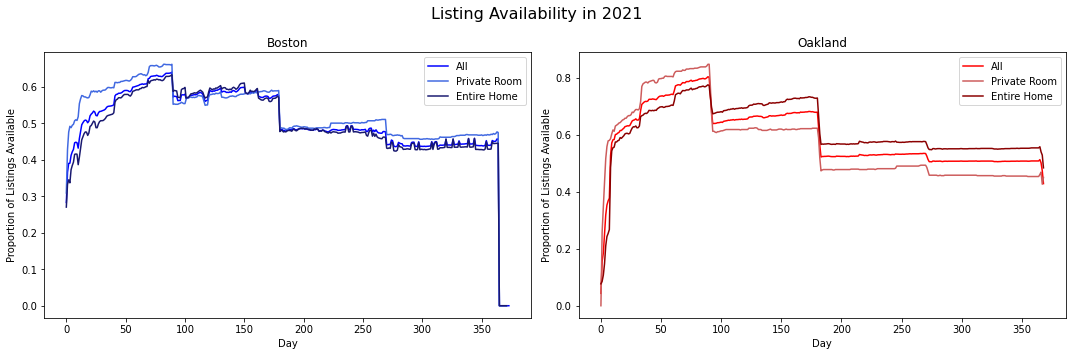

In [44]:
# Create a visualisation comparing listings availability in 2021 for both Boston and Oakland
# Include information for private rooms and entrie homes
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Listing Availability in 2021', fontsize=16)

listing_availability_boston_daily.available.plot(color="blue", ax=ax[0], label = 'All');
listing_availability_boston_daily_room.available.plot(color="royalblue", ax=ax[0], label = 'Private Room');
listing_availability_boston_daily_home.available.plot(color="midnightblue", ax=ax[0], label = 'Entire Home');
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Proportion of Listings Available');
ax[0].set_xlabel('Day');
ax[0].legend();

listing_availability_oakland_daily.available.plot(color="red", ax=ax[1], label = 'All');
listing_availability_oakland_daily_room.available.plot(color="indianred", ax=ax[1], label = 'Private Room');
listing_availability_oakland_daily_home.available.plot(color="darkred", ax=ax[1], label = 'Entire Home');
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Proportion of Listings Available');
ax[1].set_xlabel('Day');
ax[1].legend();

plt.tight_layout();

From the figure it is evident that availability increases quickly in January, followed by periods of constant availability with sharp falls at the beginning of April and at the start of July in both Boston and Oakland. There is a similar drop in availability around the start of October, but this is much smaller. It is interesting to note that the availability of listings in Oakland is consistently higher than Boston throughout the year.

What does the availability of homes in 2021 look like if we only consider homes that are available for less than 50% of the year?

In [45]:
# Determine the proportion of available listings for Boston and Oakland for each day in the calendar datasets
listing_availability_boston_75 = listing_availability_boston[listing_availability_boston['prop_available'] < 0.5]['listing_id'].to_list()
listing_availability_boston_daily_75 = calendar_boston[calendar_boston['listing_id'].isin(listing_availability_boston_75)].groupby('date').mean()['available'].reset_index()
listing_availability_oakland_75 = listing_availability_oakland[listing_availability_oakland['prop_available'] < 0.5]['listing_id'].to_list()
listing_availability_oakland_daily_75 = calendar_oakland[calendar_oakland['listing_id'].isin(listing_availability_oakland_75)].groupby('date').mean()['available'].reset_index()

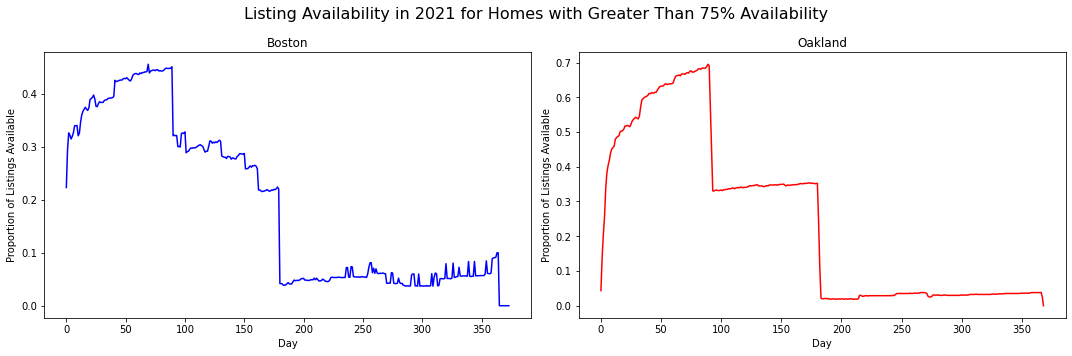

In [46]:
# Create a visualisation comparing listings availability in 2021 for homes with less than 50% availability in both Boston and Oakland
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Listing Availability in 2021 for Homes with Greater Than 75% Availability', fontsize=16)

listing_availability_boston_daily_75.available.plot(color="blue", ax=ax[0]);
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Proportion of Listings Available');
ax[0].set_xlabel('Day');

listing_availability_oakland_daily_75.available.plot(color="red", ax=ax[1]);
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Proportion of Listings Available');
ax[1].set_xlabel('Day');

plt.tight_layout();

From the chart above, homes with low availability (i.e. full time rentals) exhibit high availbility in the first half of the year and little to no availability in the second half, with the same reductions in availability around Easter and Independence Day evident. This implies that these drops in availability are due to part-time hosts returning to their homes for the holiday periods and deciding to remain for extended periods of time and make their homes unavailable.

**`3.` How much do people charge to rent their homes (on average, minimum, maximum)? How does this compare between Boston and Oakland?**


**`4.` Are there seasonality components or price spiking components for how hosts set their home prices? How does this compare between Boston and Oakland?**

For these questions, we will use the price and date fields in the calendar datasets to determine the spread of rental prices in Boston and Oakland, and whether these change throughout the year. We will also consider how property type affects pricing. First, we need to clean the price column of dollar signs and nan values.

In [47]:
# First check that there are no missing values in the price or date fields
print('Boston - number of missing values in price field:', calendar_boston.price.isnull().sum())
print('Boston - number of missing values in date field:', calendar_boston.date.isnull().sum())
print('Oakland - number of missing values in price field:', calendar_oakland.price.isnull().sum())
print('Oakland - number of missing values in date field:', calendar_oakland.date.isnull().sum())

Boston - number of missing values in price field: 0
Boston - number of missing values in date field: 0
Oakland - number of missing values in price field: 0
Oakland - number of missing values in date field: 0


In [48]:
# Clean price fields
calendar_boston['price_clean'] = calendar_boston['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))
calendar_boston_room['price_clean'] = calendar_boston_room['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))
calendar_boston_home['price_clean'] = calendar_boston_home['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))
calendar_oakland['price_clean'] = calendar_oakland['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))
calendar_oakland_room['price_clean'] = calendar_oakland_room['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))
calendar_oakland_home['price_clean'] = calendar_oakland_home['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))

In [49]:
# Print statistics for listings prices in Boston
print("Boston listings price statistics\n")
print(calendar_boston.price_clean.describe())
print("\n")
print("Boston private room listings price statistics\n")
print(calendar_boston_room.price_clean.describe())
print("\n")
print("Boston entire home listings price statistics\n")
print(calendar_boston_home.price_clean.describe())

Boston listings price statistics

count    1.133325e+06
mean     1.820178e+02
std      4.113061e+02
min      0.000000e+00
25%      7.500000e+01
50%      1.250000e+02
75%      1.990000e+02
max      1.000000e+04
Name: price_clean, dtype: float64


Boston private room listings price statistics

count    396025.000000
mean        107.967742
std         493.281748
min          10.000000
25%          48.000000
50%          64.000000
75%          90.000000
max       10000.000000
Name: price_clean, dtype: float64


Boston entire home listings price statistics

count    724160.000000
mean        213.072900
std         223.283708
min          38.000000
25%         117.000000
50%         165.000000
75%         233.000000
max        5000.000000
Name: price_clean, dtype: float64


In [50]:
# Print statistics for listings prices in Oakland
print("Oakland listings price statistics\n")
print(calendar_oakland.price_clean.describe())
print("\n")
print("Oakland private room listings price statistics\n")
print(calendar_oakland_room.price_clean.describe())
print("\n")
print("Oakland entire home listings price statistics\n")
print(calendar_oakland_home.price_clean.describe())

Oakland listings price statistics

count    839979.000000
mean        129.901273
std         171.070761
min          10.000000
25%          72.000000
50%         100.000000
75%         142.000000
max        5012.000000
Name: price_clean, dtype: float64


Oakland private room listings price statistics

count    239105.000000
mean         86.540616
std         216.744178
min          25.000000
25%          48.000000
50%          60.000000
75%          85.000000
max        5012.000000
Name: price_clean, dtype: float64


Oakland entire home listings price statistics

count    565466.000000
mean        154.097405
std         147.092221
min          10.000000
25%          97.000000
50%         120.000000
75%         160.000000
max        2500.000000
Name: price_clean, dtype: float64


In order to determine the average price of listings in Boston and Oakland, we first need to group the calendar datasets by listing_id and calculate the average price for each listing.

In [51]:
# Determine average price for each listing in Boston and Oakland
listing_avg_price_boston = calendar_boston.groupby('listing_id').mean()['price_clean'].reset_index()
listing_avg_price_boston_room = calendar_boston_room.groupby('listing_id').mean()['price_clean'].reset_index()
listing_avg_price_boston_home = calendar_boston_home.groupby('listing_id').mean()['price_clean'].reset_index()
listing_avg_price_oakland = calendar_oakland.groupby('listing_id').mean()['price_clean'].reset_index()
listing_avg_price_oakland_room = calendar_oakland_room.groupby('listing_id').mean()['price_clean'].reset_index()
listing_avg_price_oakland_home = calendar_oakland_home.groupby('listing_id').mean()['price_clean'].reset_index()

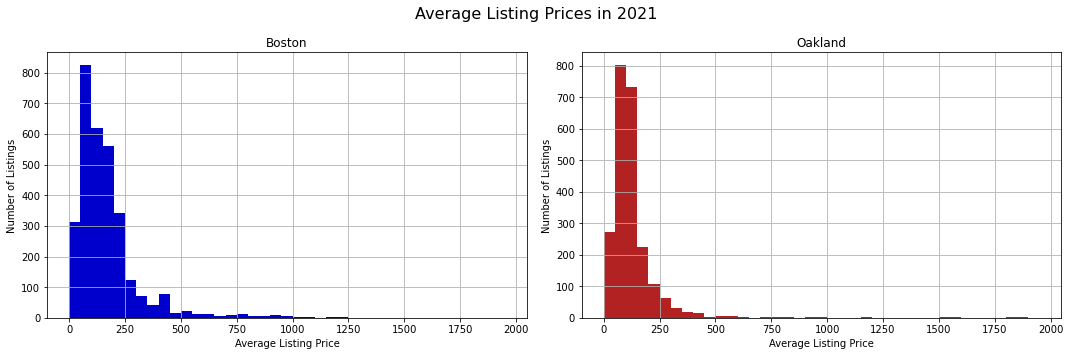

In [52]:
# Create a visualisation comparing average listings prices in Boston and Oakland
# Given the large variance in the prices of listings, only consider listings with an average price less than $2000
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Average Listing Prices in 2021', fontsize=16)

listing_avg_price_boston['price_clean'][listing_avg_price_boston['price_clean'] < 2000].hist(color="mediumblue", ax=ax[0], bins=np.arange(0,2000,50));
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Number of Listings');
ax[0].set_xlabel('Average Listing Price');

listing_avg_price_oakland['price_clean'][listing_avg_price_oakland['price_clean'] < 2000].hist(color="firebrick", ax=ax[1], bins=np.arange(0,2000,50));
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Number of Listings');
ax[1].set_xlabel('Average Listing Price');

plt.tight_layout();

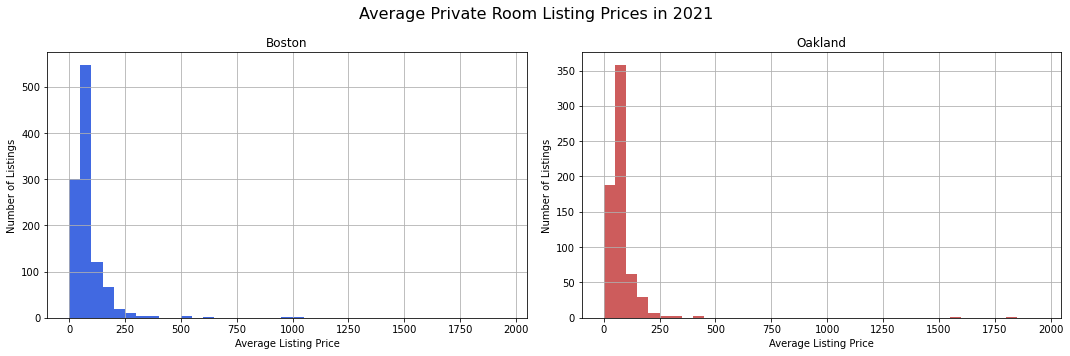

In [53]:
# Create a visualisation comparing average private room listings prices in Boston and Oakland
# Given the large variance in the prices of listings, only consider listings with an average price less than $2000
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Average Private Room Listing Prices in 2021', fontsize=16)

listing_avg_price_boston_room['price_clean'][listing_avg_price_boston_room['price_clean'] < 2000].hist(color="royalblue", ax=ax[0], bins=np.arange(0,2000,50));
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Number of Listings');
ax[0].set_xlabel('Average Listing Price');

listing_avg_price_oakland_room['price_clean'][listing_avg_price_oakland_room['price_clean'] < 2000].hist(color="indianred", ax=ax[1], bins=np.arange(0,2000,50));
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Number of Listings');
ax[1].set_xlabel('Average Listing Price');

plt.tight_layout();

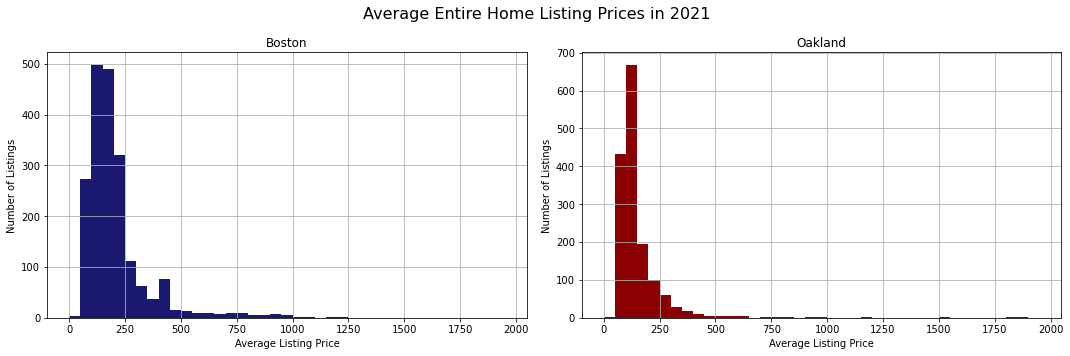

In [54]:
# Create a visualisation comparing average entire home listings prices in Boston and Oakland
# Given the large variance in the prices of listings, only consider listings with an average price less than $2000
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Average Entire Home Listing Prices in 2021', fontsize=16)

listing_avg_price_boston_home['price_clean'][listing_avg_price_boston_home['price_clean'] < 2000].hist(color="midnightblue", ax=ax[0], bins=np.arange(0,2000,50));
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Number of Listings');
ax[0].set_xlabel('Average Listing Price');

listing_avg_price_oakland_home['price_clean'][listing_avg_price_oakland_home['price_clean'] < 2000].hist(color="darkred", ax=ax[1], bins=np.arange(0,2000,50));
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Number of Listings');
ax[1].set_xlabel('Average Listing Price');

plt.tight_layout();

From the visualisations above, we can see that the distribution of average listing price appears to be very similar between Boston and Oakland homes. However, the Boston distribution is slightly more positively skewed than Oakland's (more properties with higher than average listing prices) and the maximum and average listing prices are higher.

In order to determine whether there are seasonality components or price-spiking components to how hosts set their listing prices, we will look at how the average listing price varies throughout 2021 for a selection of properties in both Boston and Oakland. We will only look at properties with a listing price less than or equal to $250 as this is the majority of listings in both Boston and Oakland, but it also makes the visualisations easier to read.

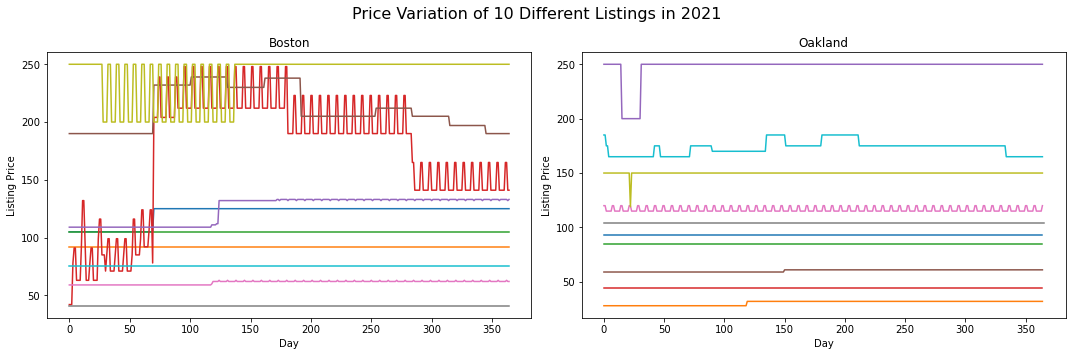

In [55]:
# Create a visualisation comparing price variations for 10 random listings in Boston and Oakland
num_listings = 10

# Create list of properties with a max price less than or equal to $250
listings_boston_max_price = calendar_boston.groupby('listing_id').max()['price_clean'].reset_index()
listings_boston_max_price_id = listings_boston_max_price['listing_id'][listings_boston_max_price['price_clean'] <= 250].to_list()
listings_oakland_max_price = calendar_oakland.groupby('listing_id').max()['price_clean'].reset_index()
listings_oakland_max_price_id = listings_oakland_max_price['listing_id'][listings_oakland_max_price['price_clean'] <= 250].to_list()

list_random_boston_id = random.sample(listings_boston_max_price_id, num_listings)
list_random_oakland_id = random.sample(listings_oakland_max_price_id, num_listings)
    
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Price Variation of {} Different Listings in 2021'.format(num_listings), fontsize=16)

for listing_id in list_random_boston_id:
    listing_price_boston = calendar_boston[calendar_boston['listing_id'] == listing_id]['price_clean'].reset_index()
    listing_price_boston.price_clean.plot(ax=ax[0], label = listing_id);
    
    
for listing_id in list_random_oakland_id:
    listing_price_oakland = calendar_oakland[calendar_oakland['listing_id'] == listing_id]['price_clean'].reset_index()
    listing_price_oakland.price_clean.plot(ax=ax[1], label = listing_id);
    
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Listing Price');
ax[0].set_xlabel('Day');
#ax[0].legend();
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Listing Price');
ax[1].set_xlabel('Day');
#ax[1].legend();

plt.tight_layout();

From the visualisation above, it can be seen that there is no obvious pattern to price fluctuations for listings in either Boston or Oakland. From the chart above it appears that some hosts fluctuate their listing price depending on the time of year, whilst others keep price relatively static. From the limited number of listings I have analysed, it appears that Boston has more variability in price than Oakland.

We can also analyse the price fluctuations for private rooms and entire homes to determine if there is any insight to be gained.

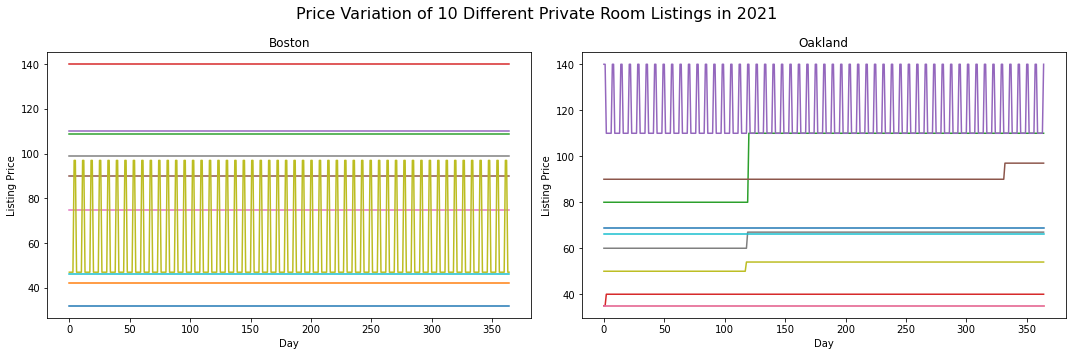

In [56]:
# Create a visualisation comparing price variations for 10 random private room listings in Boston and Oakland
num_listings_room = 10

# Create list of private room listings with a max price less than or equal to $250
listings_boston_room_max_price = calendar_boston_room.groupby('listing_id').max()['price_clean'].reset_index()
listings_boston_room_max_price_id = listings_boston_room_max_price['listing_id'][listings_boston_room_max_price['price_clean'] <= 250].to_list()
listings_oakland_room_max_price = calendar_oakland_room.groupby('listing_id').max()['price_clean'].reset_index()
listings_oakland_room_max_price_id = listings_oakland_room_max_price['listing_id'][listings_oakland_room_max_price['price_clean'] <= 250].to_list()

list_random_boston_id_room = random.sample(listings_boston_room_max_price_id, num_listings_room)
list_random_oakland_id_room = random.sample(listings_oakland_room_max_price_id, num_listings_room)
    
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Price Variation of {} Different Private Room Listings in 2021'.format(num_listings_room), fontsize=16)

for listing_id in list_random_boston_id_room:
    listing_price_boston_room = calendar_boston_room[calendar_boston_room['listing_id'] == listing_id]['price_clean'].reset_index()
    listing_price_boston_room.price_clean.plot(ax=ax[0], label = listing_id);
    
    
for listing_id in list_random_oakland_id_room:
    listing_price_oakland_room = calendar_oakland_room[calendar_oakland_room['listing_id'] == listing_id]['price_clean'].reset_index()
    listing_price_oakland_room.price_clean.plot(ax=ax[1], label = listing_id);
    
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Listing Price');
ax[0].set_xlabel('Day');
#ax[0].legend();
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Listing Price');
ax[1].set_xlabel('Day');
#ax[1].legend();

plt.tight_layout();

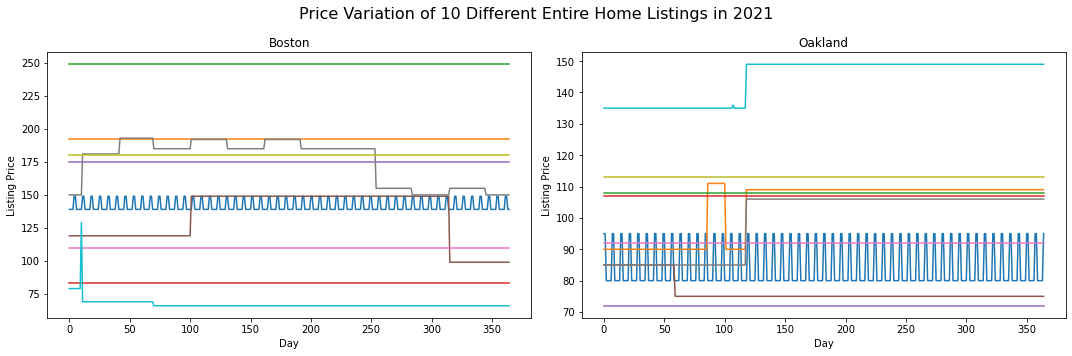

In [57]:
# Create a visualisation comparing price variations for 10 random entire home listings in Boston and Oakland
num_listings_home = 10

# Create list of entire home listings with a max price less than or equal to $250
listings_boston_home_max_price = calendar_boston_home.groupby('listing_id').max()['price_clean'].reset_index()
listings_boston_home_max_price_id = listings_boston_home_max_price['listing_id'][listings_boston_home_max_price['price_clean'] <= 250].to_list()
listings_oakland_home_max_price = calendar_oakland_home.groupby('listing_id').max()['price_clean'].reset_index()
listings_oakland_home_max_price_id = listings_oakland_home_max_price['listing_id'][listings_oakland_home_max_price['price_clean'] <= 250].to_list()

list_random_boston_id_home = random.sample(listings_boston_home_max_price_id, num_listings_home)
list_random_oakland_id_home = random.sample(listings_oakland_home_max_price_id, num_listings_home)
    
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Price Variation of {} Different Entire Home Listings in 2021'.format(num_listings_room), fontsize=16)

for listing_id in list_random_boston_id_home:
    listing_price_boston_home = calendar_boston_home[calendar_boston_home['listing_id'] == listing_id]['price_clean'].reset_index()
    listing_price_boston_home.price_clean.plot(ax=ax[0], label = listing_id);
    
    
for listing_id in list_random_oakland_id_home:
    listing_price_oakland_home = calendar_oakland_home[calendar_oakland_home['listing_id'] == listing_id]['price_clean'].reset_index()
    listing_price_oakland_home.price_clean.plot(ax=ax[1], label = listing_id);
    
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Listing Price');
ax[0].set_xlabel('Day');
#ax[0].legend();
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Listing Price');
ax[1].set_xlabel('Day');
#ax[1].legend();

plt.tight_layout();

In order to get a clearer picture of any seasonality or price-spiking components we can also analyse average variations in listing price for Boston and Oakland throughout the year.

In [58]:
# Calculate the average listing prices for each day of the year for both Boston and Oakland
# Include averages for private rooms and entire homes
avg_daily_listing_price_boston = calendar_boston.groupby('date').mean()['price_clean'].reset_index()
avg_daily_listing_price_boston_room = calendar_boston_room.groupby('date').mean()['price_clean'].reset_index()
avg_daily_listing_price_boston_home = calendar_boston_home.groupby('date').mean()['price_clean'].reset_index()
avg_daily_listing_price_oakland = calendar_oakland.groupby('date').mean()['price_clean'].reset_index()
avg_daily_listing_price_oakland_room = calendar_oakland_room.groupby('date').mean()['price_clean'].reset_index()
avg_daily_listing_price_oakland_home = calendar_oakland_home.groupby('date').mean()['price_clean'].reset_index()

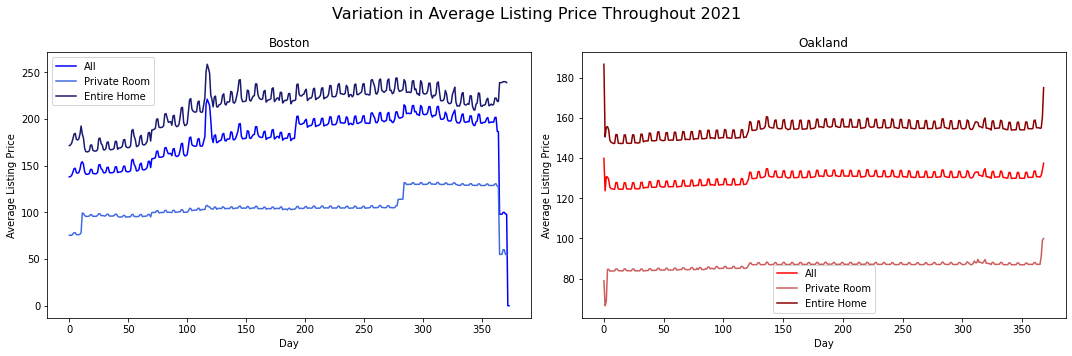

In [59]:
# Create a visualisation comparing average listings prices in Boston and Oakland through the year
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Variation in Average Listing Price Throughout 2021', fontsize=16)

avg_daily_listing_price_boston.price_clean.plot(color="blue", ax=ax[0], label = 'All');
avg_daily_listing_price_boston_room.price_clean.plot(color="royalblue", ax=ax[0], label = 'Private Room');
avg_daily_listing_price_boston_home.price_clean.plot(color="midnightblue", ax=ax[0], label = 'Entire Home');
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Average Listing Price');
ax[0].set_xlabel('Day');
ax[0].legend();

avg_daily_listing_price_oakland.price_clean.plot(color="red", ax=ax[1], label = 'All');
avg_daily_listing_price_oakland_room.price_clean.plot(color="indianred", ax=ax[1], label = 'Private Room');
avg_daily_listing_price_oakland_home.price_clean.plot(color="darkred", ax=ax[1], label = 'Entire Home');
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Average Listing Price');
ax[1].set_xlabel('Day');
ax[1].legend();

plt.tight_layout();

We can see that there are weekend spikes throughout the year in both Boston and Oakland. Price rises are more exaggerated in Boston than Oakland, and consistently increase throughout the year whereas Oakland prices stay relatively consistent. 

**`5.` Are there any property-specific amenities (i.e. Wi-Fi, TV, kitchen) that can help predict price? Which of these have the strongest influence on price? How does this compare between Boston and Oakland?**

Let's use the amenities field from the listings datasets to determine which amenities influence the price of listings. In order to exclude outlier listings in terms of price, we will only consider listings with a price less than or equal to $250. We need to clean the data to prepare it for analysis.

In [60]:
# Create list of fields within the listings datasets to be included in the analysis
# I have selected fields that have useful information and limited empty/null values
selected_fields = ['host_is_superhost',
                   'host_has_profile_pic',
                   'host_identity_verified',
                   'neighbourhood_cleansed',
                   'room_type',
                   'accommodates',
                   'amenities',
                   'price',
                   'minimum_nights',
                   'maximum_nights',
                   'availability_30',
                   'availability_60',
                   'availability_90',
                   'availability_365',
                   'number_of_reviews',
                   'review_scores_rating',
                   'review_scores_accuracy',
                   'review_scores_cleanliness',
                   'review_scores_checkin',
                   'review_scores_communication',
                   'review_scores_location',
                   'review_scores_value',
                   'instant_bookable',
                   'calculated_host_listings_count',
                   'calculated_host_listings_count_entire_homes',
                   'calculated_host_listings_count_private_rooms',
                   'calculated_host_listings_count_shared_rooms',
                   'reviews_per_month'
                  ]

In [61]:
# Create datasets with the selected fields for both Boston and Oakland
# Only include listings with a price <= $250
# All Boston listings
listings_boston_amenities = listings_boston[selected_fields]
listings_boston_amenities['price_clean'] = listings_boston_amenities['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))
listings_boston_amenities.drop(columns='price', inplace=True)
listings_boston_amenities = listings_boston_amenities[listings_boston_amenities['price_clean'] <= 250]

# All Oakland listings
listings_oakland_amenities = listings_oakland[selected_fields]
listings_oakland_amenities['price_clean'] = listings_oakland_amenities['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))
listings_oakland_amenities.drop(columns='price', inplace=True)
listings_oakland_amenities = listings_oakland_amenities[listings_oakland_amenities['price_clean'] <= 250]

Given that the amenities column contains a list of items formatted as a string, we need to convert this string into an actual list in order to process this column using sklearn's MultiLabelBinarizer. First though we will look at the unique entries in the amenities field to see if we can simply the data at all.

In [62]:
# Create list of unique values for amenities in Boston
boston_amenities_list = []
for item_list in listings_boston_amenities.amenities.to_list():
    stripped_list = ast.literal_eval(item_list)
    for item in stripped_list:
        if item not in boston_amenities_list:
            boston_amenities_list.append(item)
boston_amenities_list

['Cable TV',
 'Hangers',
 'Wifi',
 'Free street parking',
 'Kitchen',
 'Patio or balcony',
 'Carbon monoxide alarm',
 'Dishes and silverware',
 'Essentials',
 'Heating',
 'Cooking basics',
 'Extra pillows and blankets',
 'Free parking on premises',
 'Microwave',
 'Smoke alarm',
 'TV',
 'Dishwasher',
 'Coffee maker',
 'Shampoo',
 'Iron',
 'Oven',
 'Hot water',
 'Washer',
 'Stove',
 'Refrigerator',
 'Hair dryer',
 'Dedicated workspace',
 'Bed linens',
 'Air conditioning',
 'Dryer',
 'Keypad',
 'Long term stays allowed',
 'Fire extinguisher',
 'Luggage dropoff allowed',
 'Lockbox',
 'Bathtub',
 'Freezer',
 'Electric stove',
 'Pack ’n Play/travel crib',
 'Smart lock',
 'Host greets you',
 'Paid parking off premises',
 'Garden or backyard',
 'Indoor fireplace',
 'First aid kit',
 'Elevator',
 'Breakfast',
 'Hot tub',
 'Private entrance',
 'Ethernet connection',
 'Room-darkening shades',
 'Babysitter recommendations',
 'Single level home',
 'Lake access',
 'BBQ grill',
 'Lock on bedroom door

We can see that in the list of unique amenities for Boston there are numerous entries that are very similar. For example, there are lots of entries relating to TVs of different sizes or with streaming services so it would make sense to combine these into one field for TV and separate fields for each streaming service.

We will create a field for each unique item for both Boston and Oakland, and populate them using sklearn's MultiLabelBinarizer. We will then assess which fields to merge and drop.

In [63]:
# Convert amenities column to a list of lists by iterating through each row and parsing the strings
# Boston
boston_amenities_col_cleaned = []
for item_list in listings_boston_amenities.amenities.to_list():
    cleaned_list = ast.literal_eval(item_list)
    boston_amenities_col_cleaned.append(cleaned_list)

# Oakland
oakland_amenities_col_cleaned = []
for item_list in listings_oakland_amenities.amenities.to_list():
    cleaned_list = ast.literal_eval(item_list)
    oakland_amenities_col_cleaned.append(cleaned_list)

In [64]:
# Create new field in listings datasets with cleaned amenities data
listings_boston_amenities['amenities_cleaned'] = boston_amenities_col_cleaned
listings_oakland_amenities['amenities_cleaned'] = oakland_amenities_col_cleaned

In [65]:
# Use the new amenities_cleaned field to generate a binarised field for each unique amenity
mlb = MultiLabelBinarizer()

# Boston
listings_boston_amenities = listings_boston_amenities.join(pd.DataFrame(mlb.fit_transform(listings_boston_amenities.pop('amenities_cleaned')),
                                                                        columns=mlb.classes_,
                                                                        index=listings_boston_amenities.index))

# Oakland
listings_oakland_amenities = listings_oakland_amenities.join(pd.DataFrame(mlb.fit_transform(listings_oakland_amenities.pop('amenities_cleaned')),
                                                                          columns=mlb.classes_,
                                                                          index=listings_oakland_amenities.index))

In [66]:
# Remove amenities fields
listings_boston_amenities.drop(columns='amenities', inplace=True)
listings_oakland_amenities.drop(columns='amenities', inplace=True)
listings_boston_amenities.head()

host_is_superhost host_has_profile_pic host_identity_verified  \
0                 f                    t                      f   
1                 t                    t                      t   
2                 f                    t                      t   
3                 f                    t                      t   
4                 f                    t                      f   

  neighbourhood_cleansed        room_type  accommodates  minimum_nights  \
0            East Boston  Entire home/apt             2              28   
1                Roxbury  Entire home/apt             4               3   
2               Back Bay  Entire home/apt             3              28   
3              North End  Entire home/apt             2              28   
4               Back Bay  Entire home/apt             1              91   

   maximum_nights  availability_30  availability_60  ...  Wifi – 200 Mbps  \
0            1125               29               59  ...                0   
1             730                0                0  ...                0   
2            1125                0                0  ...                0   
3            1125               29               59  ...                0   
4             365                0                0  ...                0   

   Wifi – 363 Mbps  Wifi – 60 Mbps  Wifi – 600 Mbps  Wifi – 70 Mbps  \
0                0               0                0               0   
1                0               0                0               0   
2                0               0                0               0   
3                0               0                0               0   
4                0               0                0               0   

   William Roam toiletries  Window AC unit  Window guards  Wine glasses  \
0                        0               0              0             0   
1                        0               0              0             0   
2                        0               0              0             0   
3                        0               0              0             0   
4                        0               0              0             0   

   bose sound system with Bluetooth and aux  
0                                         0  
1                                         0  
2                                         0  
3                                         0  
4                                         0  

[5 rows x 243 columns]

In [67]:
# Look at new columns created to determine which fields can be combined to simplify analysis
# Boston
listings_boston_amenities_fields = [amenity for amenity in listings_boston_amenities.columns.to_list() if amenity not in selected_fields]
listings_boston_amenities_fields.remove('price_clean')

# Oakland
listings_oakland_amenities_fields = [amenity for amenity in listings_oakland_amenities.columns.to_list() if amenity not in selected_fields]
listings_oakland_amenities_fields.remove('price_clean')

listings_boston_amenities_fields

[' Bath & Body Works shampoo',
 '24-hour fitness center',
 '32" HDTV with Netflix, Amazon Prime Video',
 '40" HDTV',
 '40" HDTV with standard cable',
 '42" HDTV',
 '50" HDTV with standard cable',
 '50" TV',
 '54" HDTV with Netflix, HBO Max, Amazon Prime Video, premium cable',
 '75" TV',
 'Air conditioning',
 'Alaffia, vegan and cruelty-free body soap',
 'Alaffia, vegan and cruelty-free conditioner',
 'Alaffia, vegan and cruelty-free shampoo',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Baby safety gates',
 'Babysitter recommendations',
 'Baking sheet',
 'Barbecue utensils',
 'Bath & Body Works body soap',
 'Bath & Body Works conditioner',
 'Bath & Body Works shampoo',
 'Bathtub',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bed sheets and pillows',
 'Bike rental available',
 'Bluetooth speaker',
 'Body soap',
 'Bosch stainless steel gas stove',
 'Bosch, double ovens stainless steel oven',
 'Bread maker',
 'Breakfast',
 'Building staff',
 'Cable TV',
 'Carbon monoxide alarm',

In [68]:
# Merge similar amenities fields (such as TV and WiFi) into a list
# Create a dictionary of lists of similar fields

# Boston
boston_amenities_dict = {
    'amenities_air_conditioning': listings_boston_amenities.filter(regex='([Aa]ir conditioning|[Ff]an|AC unit)',axis=1).columns.to_list(),
    'amenities_alarms_and_safety': listings_boston_amenities.filter(regex='([Aa]lar|[Ff]ire extinguisher|[Ff]irst aid kit)',axis=1).columns.to_list(),
    'amenities_amazon_prime_video': listings_boston_amenities.filter(regex='(Amazon Prime Video)',axis=1).columns.to_list(),
    'amenities_assistance': listings_boston_amenities.filter(regex='([Bb]uilding staff|[Cc]oncierge|[Hh]ost greets you|[Hh]ousekeeping)',axis=1).columns.to_list(),
    'amenities_baby_friendly': listings_boston_amenities.filter(regex='([Bb]aby|[Cc]hanging table|[Cc]rib|[Hh]igh chair)',axis=1).columns.to_list(),
    'amenities_bbq': listings_boston_amenities.filter(regex='([Bb]arbecue|BBQ)',axis=1).columns.to_list(),
    'amenities_bedroom_essentials': listings_boston_amenities.filter(regex='([Bb]ed linens|[Bb]ed sheets|[Pp]illows)',axis=1).columns.to_list(),
    'amenities_bikes': listings_boston_amenities.filter(regex='([Bb]ike)',axis=1).columns.to_list(),
    'amenities_children_friendly': listings_boston_amenities.filter(regex='([Cc]hildren|[Tt]able corner guards|[Ww]indow guards)',axis=1).columns.to_list(),
    'amenities_chromecast': listings_boston_amenities.filter(regex='([Cc]hromecast)',axis=1).columns.to_list(),
    'amenities_cleaning': listings_boston_amenities.filter(regex='([Cc]leaning)',axis=1).columns.to_list(),
    'amenities_clothing_storage': listings_boston_amenities.filter(regex='([Cc]lothing storage)',axis=1).columns.to_list(),
    'amenities_coffee_machine': listings_boston_amenities.filter(regex='([Cc]offee|[Nn]espresso machine)',axis=1).columns.to_list(),
    'amenities_complimentary_food': listings_boston_amenities.filter(regex='([Bb]reakfast)',axis=1).columns.to_list(),
    'amenities_dryer': listings_boston_amenities.filter(regex='(?<!Hair )([Dd]ryer)',axis=1).columns.to_list(),
    'amenities_fireplace': listings_boston_amenities.filter(regex='([Ff]ireplace)',axis=1).columns.to_list(),
    'amenities_free_parking': listings_boston_amenities.filter(regex='([Ff]ree carport|[Ff]ree parking|[Ff]ree driveway|[Ff]ree residential|[Ff]ree street)',axis=1).columns.to_list(),
    'amenities_games': listings_boston_amenities.filter(regex='([Gg]ame)',axis=1).columns.to_list(),
    'amenities_gym': listings_boston_amenities.filter(regex='([Ff]itness|[Gg]ym)',axis=1).columns.to_list(),
    'amenities_hbo_max': listings_boston_amenities.filter(regex='(HBO Max)',axis=1).columns.to_list(),
    'amenities_hdtv': listings_boston_amenities.filter(regex='(HDTV)',axis=1).columns.to_list(),
    'amenities_heating': listings_boston_amenities.filter(regex='([Hh]eating)',axis=1).columns.to_list(),
    'amenities_netflix': listings_boston_amenities.filter(regex='([Nn]etflix)',axis=1).columns.to_list(),
    'amenities_oven': listings_boston_amenities.filter(regex='([Oo]ven)',axis=1).columns.to_list(),
    'amenities_paid_parking': listings_boston_amenities.filter(regex='([Pp]aid parking|[Pp]aid street|[Ss]elf-parking)',axis=1).columns.to_list(),
    'amenities_premium_cable': listings_boston_amenities.filter(regex='([Pp]remium cable)',axis=1).columns.to_list(),
    'amenities_refrigerator': listings_boston_amenities.filter(regex='([Rr]efrigerator|[Ff]ridge)',axis=1).columns.to_list(),
    'amenities_security': listings_boston_amenities.filter(regex='([Kk]eypad|[Ll]ock|[Pp]rivate entrance)',axis=1).columns.to_list(),
    'amenities_sound_system': listings_boston_amenities.filter(regex='([Ss]ound system|[Bb]luetooth speaker)',axis=1).columns.to_list(),
    'amenities_standard_cable': listings_boston_amenities.filter(regex='([Ss]tandard cable)',axis=1).columns.to_list(),
    'amenities_stove': listings_boston_amenities.filter(regex='([Ss]tove)',axis=1).columns.to_list(),
    'amenities_toiletries': listings_boston_amenities.filter(regex='([Ss]hampoo|[Cc]onditioner|[Ss]oap|[Ss]hower gel|[Tt]oiletries)',axis=1).columns.to_list(),
    'amenities_tv': listings_boston_amenities.filter(regex='(?<!HD)(TV)',axis=1).columns.to_list(),
    'amenities_washing_machine': listings_boston_amenities.filter(regex='(?<!Dish)([Ww]asher)',axis=1).columns.to_list(),
    'amenities_wifi': listings_boston_amenities.filter(regex='([Ww][Ii][Ff][Ii])',axis=1).columns.to_list(),
    'amenities_workspace': listings_boston_amenities.filter(regex='([Ww]orkspace)',axis=1).columns.to_list()
}

# Oakland
oakland_amenities_dict = {
    'amenities_air_conditioning': listings_oakland_amenities.filter(regex='([Aa]ir conditioning|[Ff]an|AC unit)',axis=1).columns.to_list(),
    'amenities_alarms_and_safety': listings_oakland_amenities.filter(regex='([Aa]lar|[Ff]ire extinguisher|[Ff]irst aid kit)',axis=1).columns.to_list(),
    'amenities_amazon_prime_video': listings_oakland_amenities.filter(regex='(Amazon Prime Video)',axis=1).columns.to_list(),
    'amenities_assistance': listings_oakland_amenities.filter(regex='([Bb]uilding staff|[Hh]ost greets you)',axis=1).columns.to_list(),
    'amenities_baby_friendly': listings_oakland_amenities.filter(regex='([Bb]aby|[Cc]hanging table|[Cc]rib|[Hh]igh chair)',axis=1).columns.to_list(),
    'amenities_bbq': listings_oakland_amenities.filter(regex='([Bb]arbecue|BBQ)',axis=1).columns.to_list(),
    'amenities_bedroom_essentials': listings_oakland_amenities.filter(regex='([Bb]ed linens|[Bb]edroom comforts|[Pp]illows)',axis=1).columns.to_list(),
    'amenities_children_friendly': listings_oakland_amenities.filter(regex='([Cc]hildren|[Tt]able corner guards|[Ww]indow guards)',axis=1).columns.to_list(),
    'amenities_chromecast': listings_oakland_amenities.filter(regex='([Cc]hromecast)',axis=1).columns.to_list(),
    'amenities_cleaning': listings_oakland_amenities.filter(regex='([Cc]leaning)',axis=1).columns.to_list(),
    'amenities_clothing_storage': listings_oakland_amenities.filter(regex='([Cc]lothing storage)',axis=1).columns.to_list(),
    'amenities_coffee_machine': listings_oakland_amenities.filter(regex='([Cc]offee|[Nn]espresso)',axis=1).columns.to_list(),
    'amenities_complimentary_food': listings_oakland_amenities.filter(regex='([Bb]reakfast)',axis=1).columns.to_list(),
    'amenities_dryer': listings_oakland_amenities.filter(regex='(?<!Hair )([Dd]ryer)',axis=1).columns.to_list(),
    'amenities_fireplace': listings_oakland_amenities.filter(regex='([Ff]ireplace)',axis=1).columns.to_list(),
    'amenities_free_parking': listings_oakland_amenities.filter(regex='([Ff]ree carport|[Ff]ree parking|[Ff]ree driveway|[Ff]ree residential|[Ff]ree street)',axis=1).columns.to_list(),
    'amenities_games': listings_oakland_amenities.filter(regex='([Gg]ame)',axis=1).columns.to_list(),
    'amenities_gym': listings_oakland_amenities.filter(regex='([Gg]ym)',axis=1).columns.to_list(),
    'amenities_hbo_max': listings_oakland_amenities.filter(regex='(HBO Max)',axis=1).columns.to_list(),
    'amenities_hdtv': listings_oakland_amenities.filter(regex='(HDTV)',axis=1).columns.to_list(),
    'amenities_heating': listings_oakland_amenities.filter(regex='([Hh]eating)',axis=1).columns.to_list(),
    'amenities_kitchen': listings_oakland_amenities.filter(regex='([Kk]itchen)',axis=1).columns.to_list(),
    'amenities_microwave': listings_oakland_amenities.filter(regex='([Mm]icrowave)',axis=1).columns.to_list(),
    'amenities_netflix': listings_oakland_amenities.filter(regex='([Nn]etflix)',axis=1).columns.to_list(),
    'amenities_oven': listings_oakland_amenities.filter(regex='([Oo]ven)',axis=1).columns.to_list(),
    'amenities_paid_parking': listings_oakland_amenities.filter(regex='([Pp]aid parking|[Pp]aid street)',axis=1).columns.to_list(),
    'amenities_premium_cable': listings_oakland_amenities.filter(regex='([Pp]remium cable)',axis=1).columns.to_list(),
    'amenities_refrigerator': listings_oakland_amenities.filter(regex='([Rr]efrigerator|[Ff]ridge)',axis=1).columns.to_list(),
    'amenities_roku': listings_oakland_amenities.filter(regex='([Rr]oku)',axis=1).columns.to_list(),
    'amenities_security': listings_oakland_amenities.filter(regex='([Kk]eypad|[Ll]ock|[Pp]rivate entrance)',axis=1).columns.to_list(),
    'amenities_sound_system': listings_oakland_amenities.filter(regex='([Ss]ound system)',axis=1).columns.to_list(),
    'amenities_standard_cable': listings_oakland_amenities.filter(regex='([Ss]tandard cable)',axis=1).columns.to_list(),
    'amenities_stove': listings_oakland_amenities.filter(regex='([Ss]tove)',axis=1).columns.to_list(),
    'amenities_toiletries': listings_oakland_amenities.filter(regex='([Ss]hampoo|[Cc]onditioner|[Ss]oap|[Bb]athroom essentials)',axis=1).columns.to_list(),
    'amenities_tv': listings_oakland_amenities.filter(regex='(?<!HD)(TV)',axis=1).columns.to_list(),
    'amenities_washing_machine': listings_oakland_amenities.filter(regex='(?<!Dish)([Ww]asher)',axis=1).columns.to_list(),
    'amenities_wifi': listings_oakland_amenities.filter(regex='([Ww][Ii][Ff][Ii])',axis=1).columns.to_list()
}

In [69]:
# Use each list of similar fields to subset the listings dataset and iterate through each listing
# If any of the similar fields have a 1, then add 1 to the new field

# Boston
boston_amenities_merged_values = []
for key in boston_amenities_dict:
    boston_amenities_subset = listings_boston_amenities[boston_amenities_dict[key]]
    boston_amenities_subset_values = []
    #for i in range(0, boston_amenities_subset.shape[0]):
    #    if boston_amenities_subset.iloc[[i]].sum(axis=1)[i] >= 1:
    for index, row in boston_amenities_subset.iterrows():
        if row[boston_amenities_dict[key]].sum() >= 1:
            boston_amenities_subset_values.append(1)
        else:
            boston_amenities_subset_values.append(0)
    boston_amenities_merged_values.append(boston_amenities_subset_values)
    
# Oakland
oakland_amenities_merged_values = []
for key in oakland_amenities_dict:
    oakland_amenities_subset = listings_oakland_amenities[oakland_amenities_dict[key]]
    oakland_amenities_subset_values = []
    #for i in range(0, oakland_amenities_subset.shape[0]):
    #    if oakland_amenities_subset.iloc[[i]].sum(axis=1)[i] >= 1:
    for index, row in oakland_amenities_subset.iterrows():
        if row[oakland_amenities_dict[key]].sum() >= 1:
            oakland_amenities_subset_values.append(1)
        else:
            oakland_amenities_subset_values.append(0)
    oakland_amenities_merged_values.append(oakland_amenities_subset_values)

In [70]:
# Create dicts with new merged amenities fields for Boston and Oakland
boston_amenities_merged_cols = list(boston_amenities_dict.keys())
boston_amenities_merged_dict = dict(zip(boston_amenities_merged_cols, boston_amenities_merged_values))
oakland_amenities_merged_cols = list(oakland_amenities_dict.keys())
oakland_amenities_merged_dict = dict(zip(oakland_amenities_merged_cols, oakland_amenities_merged_values))

In [71]:
# Create dataframes of new merged amenities fields and values for Boston and Oakland
boston_amenities_merged = pd.DataFrame.from_dict(boston_amenities_merged_dict)
boston_amenities_merged = boston_amenities_merged.set_index(listings_boston_amenities.index)
oakland_amenities_merged = pd.DataFrame.from_dict(oakland_amenities_merged_dict)
oakland_amenities_merged = oakland_amenities_merged.set_index(listings_oakland_amenities.index) 
boston_amenities_merged.head()

amenities_air_conditioning  amenities_alarms_and_safety  \
0                           1                            1   
1                           1                            1   
2                           1                            1   
3                           1                            1   
4                           1                            1   

   amenities_amazon_prime_video  amenities_assistance  \
0                             0                     0   
1                             0                     0   
2                             0                     0   
3                             0                     0   
4                             0                     0   

   amenities_baby_friendly  amenities_bbq  amenities_bedroom_essentials  \
0                        0              0                             1   
1                        0              0                             0   
2                        0              0                             0   
3                        0              0                             1   
4                        0              0                             1   

   amenities_bikes  amenities_children_friendly  amenities_chromecast  ...  \
0                0                            0                     0  ...   
1                0                            0                     0  ...   
2                0                            0                     0  ...   
3                0                            0                     0  ...   
4                0                            0                     0  ...   

   amenities_refrigerator  amenities_security  amenities_sound_system  \
0                       1                   0                       0   
1                       1                   1                       0   
2                       1                   0                       0   
3                       1                   1                       0   
4                       1                   0                       0   

   amenities_standard_cable  amenities_stove  amenities_toiletries  \
0                         0                1                     1   
1                         0                1                     1   
2                         0                1                     1   
3                         0                0                     0   
4                         0                1                     0   

   amenities_tv  amenities_washing_machine  amenities_wifi  \
0             1                          1               1   
1             1                          1               1   
2             1                          0               1   
3             1                          0               1   
4             1                          1               1   

   amenities_workspace  
0                    1  
1                    1  
2                    1  
3                    1  
4                    0  

[5 rows x 36 columns]

In [72]:
# Create lists of amenities columns that have been merged for Boston and Oakland
boston_amenities_drop_cols = []
for key in boston_amenities_dict:
    cols_list = boston_amenities_dict[key]
    for col in cols_list:
        if col not in boston_amenities_drop_cols:
            boston_amenities_drop_cols.append(col)
            
oakland_amenities_drop_cols = []
for key in oakland_amenities_dict:
    cols_list = oakland_amenities_dict[key]
    for col in cols_list:
        if col not in oakland_amenities_drop_cols:
            oakland_amenities_drop_cols.append(col)

In [73]:
# Drop amenities columns that have been merged from listings_boston_amenities and listings_oakland_amenities
listings_boston_amenities.drop(columns=boston_amenities_drop_cols, inplace=True)
listings_oakland_amenities.drop(columns=oakland_amenities_drop_cols, inplace=True)

In [74]:
# Add new merged amenities columns
listings_boston_amenities_cleaned = pd.concat([listings_boston_amenities, boston_amenities_merged], axis=1)
listings_oakland_amenities_cleaned = pd.concat([listings_oakland_amenities, oakland_amenities_merged], axis=1)
listings_boston_amenities_cleaned

host_is_superhost host_has_profile_pic host_identity_verified  \
0                    f                    t                      f   
1                    t                    t                      t   
2                    f                    t                      t   
3                    f                    t                      t   
4                    f                    t                      f   
...                ...                  ...                    ...   
3101                 t                    t                      t   
3102                 f                    t                      t   
3103                 t                    t                      t   
3104                 f                    t                      t   
3105                 f                    t                      t   

     neighbourhood_cleansed        room_type  accommodates  minimum_nights  \
0               East Boston  Entire home/apt             2              28   
1                   Roxbury  Entire home/apt             4               3   
2                  Back Bay  Entire home/apt             3              28   
3                 North End  Entire home/apt             2              28   
4                  Back Bay  Entire home/apt             1              91   
...                     ...              ...           ...             ...   
3101          Jamaica Plain     Private room             2              28   
3102               Downtown  Entire home/apt             2              30   
3103            East Boston  Entire home/apt             3              91   
3104             Roslindale  Entire home/apt             2               3   
3105            Bay Village     Private room             2               1   

      maximum_nights  availability_30  availability_60  ...  \
0               1125               29               59  ...   
1                730                0                0  ...   
2               1125                0                0  ...   
3               1125               29               59  ...   
4                365                0                0  ...   
...              ...              ...              ...  ...   
3101            1125               30               60  ...   
3102            1125               25               55  ...   
3103             365                0               12  ...   
3104              90               24               54  ...   
3105              45                0               29  ...   

      amenities_refrigerator  amenities_security  amenities_sound_system  \
0                          1                   0                       0   
1                          1                   1                       0   
2                          1                   0                       0   
3                          1                   1                       0   
4                          1                   0                       0   
...                      ...                 ...                     ...   
3101                       0                   1                       0   
3102                       0                   0                       0   
3103                       1                   1                       0   
3104                       0                   0                       0   
3105                       0                   0                       0   

      amenities_standard_cable  amenities_stove  amenities_toiletries  \
0                            0                1                     1   
1                            0                1                     1   
2                            0                1                     1   
3                            0                0                     0   
4                            0                1                     0   
...                        ...              ...                   ...   
3101                         0                

In [75]:
# Update lists of amenities fields
listings_boston_amenities_fields = [amenity for amenity in listings_boston_amenities_cleaned.columns.to_list() if amenity not in selected_fields]
listings_boston_amenities_fields.remove('price_clean')
listings_oakland_amenities_fields = [amenity for amenity in listings_oakland_amenities_cleaned.columns.to_list() if amenity not in selected_fields]
listings_oakland_amenities_fields.remove('price_clean')

Before re-encoding the original fields, we should assess how much missing data there is in each column of the cleaned dataset.

In [76]:
# Perform an assessment of how much missing data there is in each column of the dataset for Boston
miss_vals_boston = []

for col in listings_boston_amenities_cleaned.columns:
    miss_vals_boston.append(
        {
            'column': col,
            'missing_values': listings_boston_amenities_cleaned[col].isnull().sum()
        }
    )

miss_vals_df_boston = pd.DataFrame(miss_vals_boston)
miss_vals_df_boston.head()

column  missing_values
0       host_is_superhost               0
1    host_has_profile_pic               0
2  host_identity_verified               0
3  neighbourhood_cleansed               0
4               room_type               0

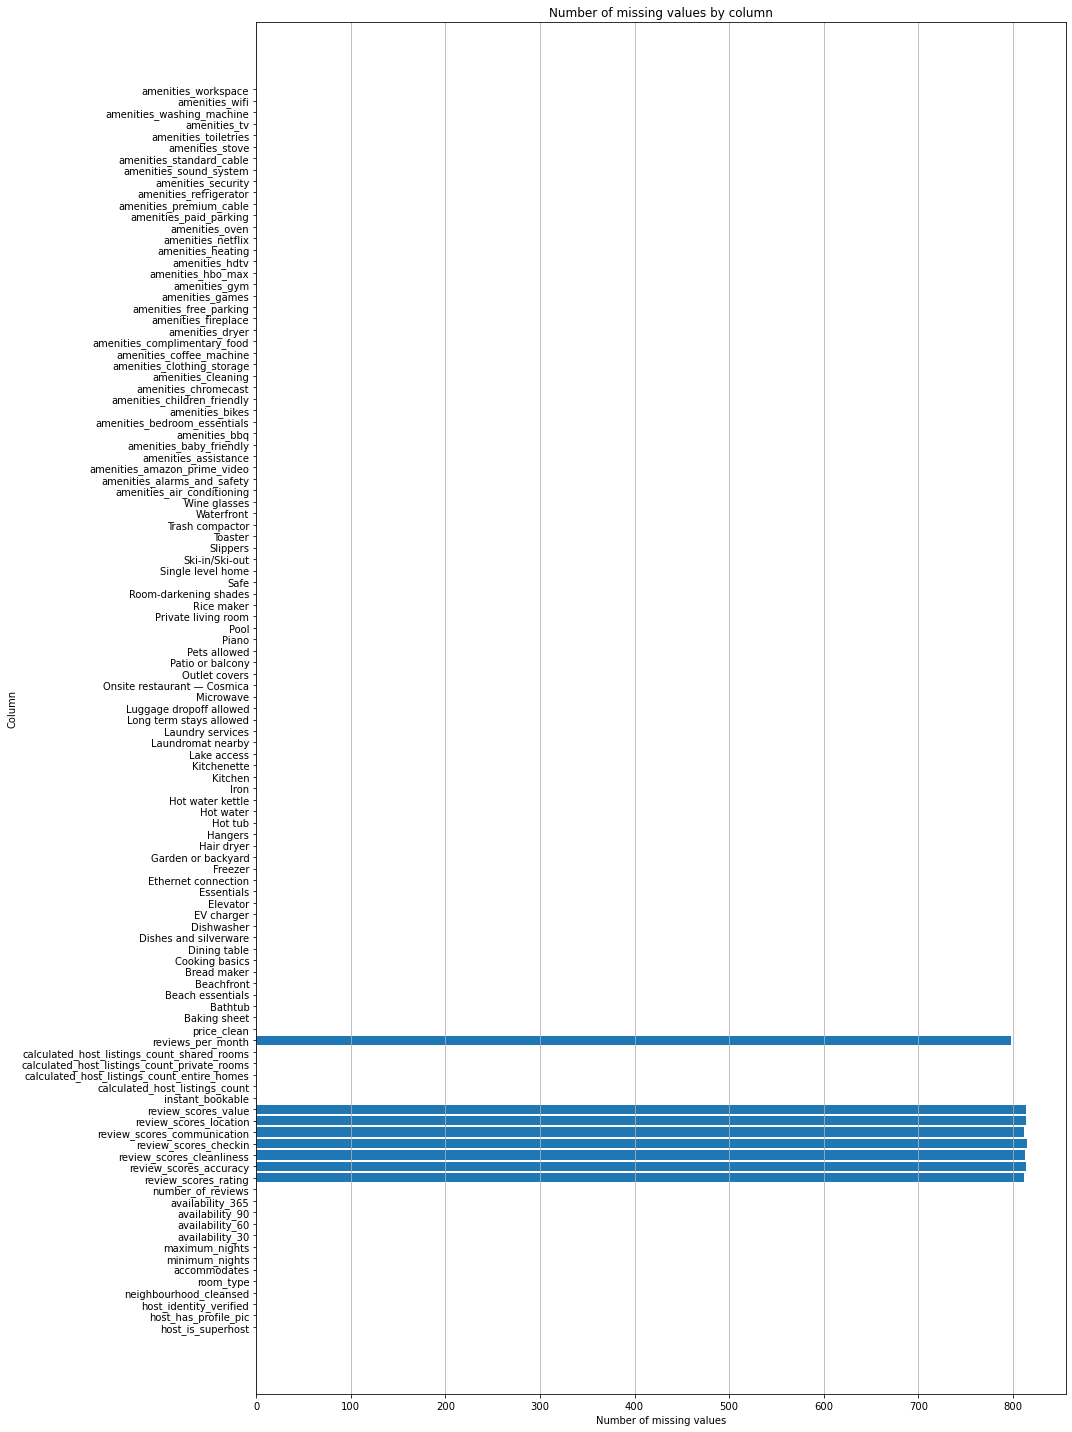

In [77]:
# Plot a bar chart of missing values for each column in Boston dataset
fig = plt.figure(figsize = (15, 20))
plt.barh(miss_vals_df_boston['column'], miss_vals_df_boston['missing_values'], align='center')
plt.xlabel("Number of missing values")
plt.ylabel("Column")
plt.title("Number of missing values by column")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [78]:
# Perform an assessment of how much missing data there is in each column of the dataset for Oakland
miss_vals_oakland = []

for col in listings_oakland_amenities_cleaned.columns:
    miss_vals_oakland.append(
        {
            'column': col,
            'missing_values': listings_oakland_amenities_cleaned[col].isnull().sum()
        }
    )

miss_vals_df_oakland = pd.DataFrame(miss_vals_oakland)
miss_vals_df_oakland.head()

column  missing_values
0       host_is_superhost               0
1    host_has_profile_pic               0
2  host_identity_verified               0
3  neighbourhood_cleansed               0
4               room_type               0

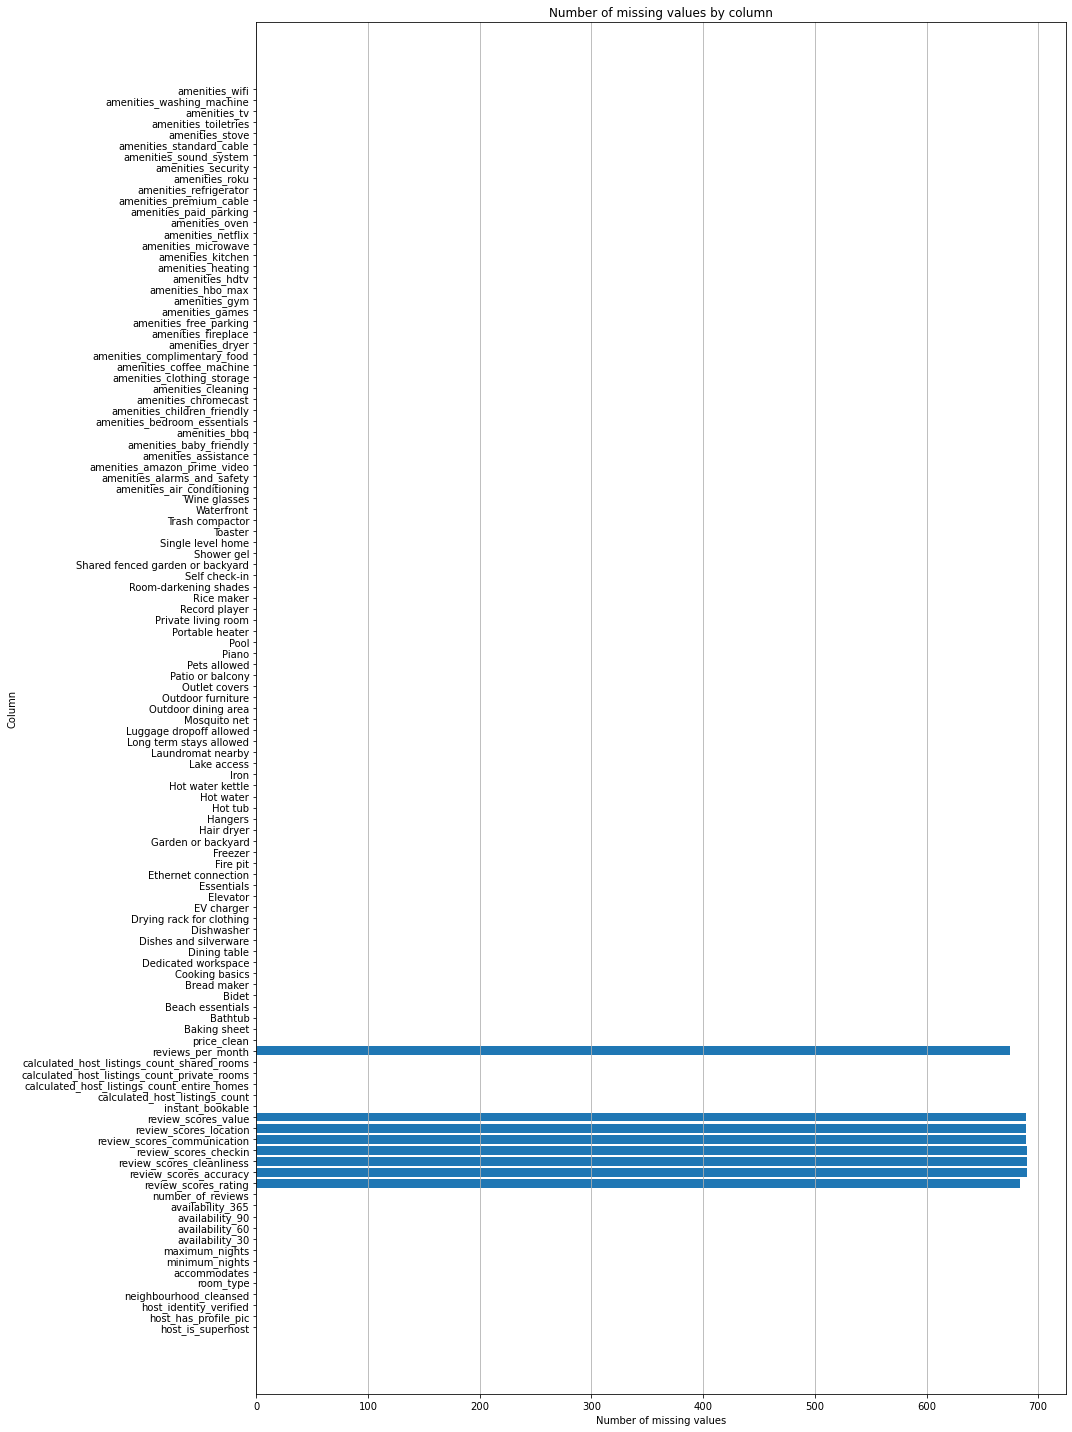

In [79]:
# Plot a bar chart of missing values for each column in Oakland dataset
fig = plt.figure(figsize = (15, 20))
plt.barh(miss_vals_df_oakland['column'], miss_vals_df_oakland['missing_values'], align='center')
plt.xlabel("Number of missing values")
plt.ylabel("Column")
plt.title("Number of missing values by column")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

From the charts above it is clear that only the review_scores and reviews_per_month columns have any missing values. Although the proportion of missing values for these columns is less than 30%, it would be better to drop these fields rather than impute values.

In [80]:
# Identify columns with count of missing_values > 0 in Boston dataset
miss_vals_drop_cols_boston = []
for index, row in miss_vals_df_boston.iterrows():
    if row['missing_values'] > 0:
        miss_vals_drop_cols_boston.append(row['column'])

miss_vals_drop_cols_boston

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [81]:
# Identify columns with count of missing_values > 0 in Oaklan dataset
miss_vals_drop_cols_oakland = []
for index, row in miss_vals_df_oakland.iterrows():
    if row['missing_values'] > 0:
        miss_vals_drop_cols_oakland.append(row['column'])

miss_vals_drop_cols_oakland

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [82]:
# Drop fields with missing values
listings_boston_amenities_cleaned.drop(columns=miss_vals_drop_cols_boston, inplace=True)
listings_oakland_amenities_cleaned.drop(columns=miss_vals_drop_cols_oakland, inplace=True)

First, we will re-encode the categorical features.

In [83]:
# Convert binary categorical variables into numeric values (i.e. 1 and 0) for both Boston and Oakland datasets
bin_cat_vars = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
for feature in bin_cat_vars:
    listings_boston_amenities_cleaned[feature].replace(to_replace={'t':1, 'f':0}, inplace=True)
    listings_oakland_amenities_cleaned[feature].replace(to_replace={'t':1, 'f':0}, inplace=True)

In [84]:
# Re-encode multi-level categorical features using multiple dummy variables for both Boston and Oakland datasets
multi_cat_vars_boston = listings_boston_amenities_cleaned.select_dtypes(include=['object']).columns.to_list()
multi_cat_vars_oakland = listings_oakland_amenities_cleaned.select_dtypes(include=['object']).columns.to_list()

listings_boston_amenities_cleaned = pd.get_dummies(listings_boston_amenities_cleaned, columns=multi_cat_vars_boston)
listings_oakland_amenities_cleaned = pd.get_dummies(listings_oakland_amenities_cleaned, columns=multi_cat_vars_oakland)

Next, we will normalise the numerical fields.

In [85]:
# Initialize a scaler, then apply it to the features in both Boston and Oakland datasets
scaler = MinMaxScaler()
numerical_boston = listings_boston_amenities_cleaned.select_dtypes(include=['int','uint8','float']).columns.to_list()
numerical_oakland = listings_oakland_amenities_cleaned.select_dtypes(include=['int','uint8','float']).columns.to_list()

listings_boston_amenities_cleaned_norm = pd.DataFrame(data = listings_boston_amenities_cleaned)
listings_boston_amenities_cleaned_norm[numerical_boston] = scaler.fit_transform(listings_boston_amenities_cleaned[numerical_boston])
listings_oakland_amenities_cleaned_norm = pd.DataFrame(data = listings_oakland_amenities_cleaned)
listings_oakland_amenities_cleaned_norm[numerical_oakland] = scaler.fit_transform(listings_oakland_amenities_cleaned[numerical_oakland])

listings_boston_amenities_cleaned_norm.head()

host_is_superhost  host_has_profile_pic  host_identity_verified  \
0                0.0                   1.0                     0.0   
1                1.0                   1.0                     1.0   
2                0.0                   1.0                     1.0   
3                0.0                   1.0                     1.0   
4                0.0                   1.0                     0.0   

   accommodates  minimum_nights  maximum_nights  availability_30  \
0      0.071429        0.027027        0.112422         0.966667   
1      0.214286        0.002002        0.072915         0.000000   
2      0.142857        0.027027        0.112422         0.000000   
3      0.071429        0.027027        0.112422         0.966667   
4      0.000000        0.090090        0.036407         0.000000   

   availability_60  availability_90  availability_365  ...  \
0         0.983333         0.988889          0.693151  ...   
1         0.000000         0.000000          0.000000  ...   
2         0.000000         0.000000          0.000000  ...   
3         0.983333         0.988889          0.997260  ...   
4         0.000000         0.000000          0.000000  ...   

   neighbourhood_cleansed_Roxbury  neighbourhood_cleansed_South Boston  \
0                             0.0                                  0.0   
1                             1.0                                  0.0   
2                             0.0                                  0.0   
3                             0.0                                  0.0   
4                             0.0                                  0.0   

   neighbourhood_cleansed_South Boston Waterfront  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   neighbourhood_cleansed_South End  neighbourhood_cleansed_West End  \
0                               0.0                              0.0   
1                               0.0                              0.0   
2                               0.0                              0.0   
3                               0.0                              0.0   
4                               0.0                              0.0   

   neighbourhood_cleansed_West Roxbury  room_type_Entire home/apt  \
0                                  0.0                        1.0   
1                                  0.0                        1.0   
2                                  0.0                        1.0   
3                                  0.0                        1.0   
4                                  0.0                        1.0   

   room_type_Hotel room  room_type_Private room  room_type_Shared room  
0                   0.0                     0.0                    0.0  
1                   0.0                     0.0                    0.0  
2                   0.0                     0.0                    0.0  
3                   0.0                     0.0                    0.0  
4                   0.0                     0.0                    0.0  

[5 rows x 128 columns]

In [86]:
# Check the number of rows and columns in the datasets
print('Boston dataset: rows =', listings_boston_amenities_cleaned_norm.shape[0], '; columns =', listings_boston_amenities_cleaned_norm.shape[1])
print('Oakland dataset: rows =', listings_oakland_amenities_cleaned_norm.shape[0], '; columns =', listings_oakland_amenities_cleaned_norm.shape[1])

Boston dataset: rows = 2805 ; columns = 128
Oakland dataset: rows = 2145 ; columns = 225


Now that we have cleaned and normalised our dataset, in order to determine if there any property-specific amenities (i.e. Wi-Fi, TV, kitchen) that can help predict price we will split the datasets into training and testing sets, fit a regression model to the training set, and use it to predict the price of listings in the testing set. We will then assess the feature importances in order to determine which property-specific amenities have the greatest influence on listing price.

In [87]:
# Split datasets into explanatory matrices (X) and response vectors (y)

# Boston
cols_excl_price_boston = []
for col in listings_boston_amenities_cleaned_norm.columns.to_list():
    if col != 'price_clean':
        cols_excl_price_boston.append(col)
        
X_boston = listings_boston_amenities_cleaned_norm[cols_excl_price_boston]
y_boston = listings_boston_amenities_cleaned_norm[['price_clean']]

# Oakland
cols_excl_price_oakland = []
for col in listings_oakland_amenities_cleaned_norm.columns.to_list():
    if col != 'price_clean':
        cols_excl_price_oakland.append(col)
        
X_oakland = listings_oakland_amenities_cleaned_norm[cols_excl_price_oakland]
y_oakland = listings_oakland_amenities_cleaned_norm[['price_clean']]

In [88]:
# Split into train and test sets
X_boston_train, X_boston_test, y_boston_train, y_boston_test = train_test_split(X_boston, y_boston, test_size=0.3, random_state=42)
X_oakland_train, X_oakland_test, y_oakland_train, y_oakland_test = train_test_split(X_oakland, y_oakland, test_size=0.3, random_state=42)

In [89]:
# Instantiate and fit AdaBoostRegressor model on the datasets
model_boston = AdaBoostRegressor(DecisionTreeRegressor(max_depth=40), n_estimators=1000, learning_rate=0.01, random_state=42)
model_oakland = AdaBoostRegressor(DecisionTreeRegressor(max_depth=40), n_estimators=1000, learning_rate=0.01, random_state=42)
model_boston.fit(X_boston_train, y_boston_train.values.ravel())
model_oakland.fit(X_oakland_train, y_oakland_train.values.ravel())

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=40),
                  learning_rate=0.01, n_estimators=1000, random_state=42)

In [90]:
# Predict using the models

# Boston
y_boston_train_preds = model_boston.predict(X_boston_train)
y_boston_test_preds = model_boston.predict(X_boston_test)

# Oakland
y_oakland_train_preds = model_oakland.predict(X_oakland_train)
y_oakland_test_preds = model_oakland.predict(X_oakland_test)

In [91]:
# Score the model predictions

# Boston
train_score_boston = r2_score(y_boston_train.values.ravel(), y_boston_train_preds)
test_score_boston = r2_score(y_boston_test.values.ravel(), y_boston_test_preds)

# Oakland
train_score_oakland = r2_score(y_oakland_train.values.ravel(), y_oakland_train_preds)
test_score_oakland = r2_score(y_oakland_test.values.ravel(), y_oakland_test_preds)

# Print results
print('Boston model scores\n')
print('Score on training set:', train_score_boston)
print('Score on testing set', test_score_boston)
print('\n')
print('Oakland model scores\n')
print('Score on training set:', train_score_oakland)
print('Score on testing set', test_score_oakland)

Boston model scores

Score on training set: 0.9997769859906155
Score on testing set 0.6413947431069391


Oakland model scores

Score on training set: 0.9947090697818562
Score on testing set 0.6923260003579914


We can look at the feature importances of the models as an indication of the influence of each field on the price of a listings in Boston and Oakland respectively. The larger the value, the greater the expected impact on price.

In [92]:
# Create a table listing the most important features for predicting listing price for Boston and Oakland
def feature_importances(feature_importances, X_train):
    '''
    INPUT:
    feature_importances - the feature importances of the regression model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    feature_importance_df - a dataframe holding the feature and its importance
    
    Provides a dataframe that can be used to understand the most influential features
    in a regression model by providing the feature importances along with the name of the 
    feature.
    '''
    feature_importance_df = pd.DataFrame()
    feature_importance_df['feature'] = X_train.columns
    feature_importance_df['feature_importance'] = feature_importances.flatten()
    feature_importance_df = feature_importance_df.sort_values('feature_importance', ascending=False)
    return feature_importance_df

In [93]:
# Looking at Boston's most important features
feature_importance_boston = feature_importances(model_boston.feature_importances_, X_boston_train)
feature_importance_boston.head(20)

feature  feature_importance
123                     room_type_Entire home/apt            0.238435
3                                    accommodates            0.073470
10                              number_of_reviews            0.057997
4                                  minimum_nights            0.040074
9                                availability_365            0.034587
12                 calculated_host_listings_count            0.030434
13    calculated_host_listings_count_entire_homes            0.028486
5                                  maximum_nights            0.023747
8                                 availability_90            0.016257
6                                 availability_30            0.015977
14   calculated_host_listings_count_private_rooms            0.015973
80                                  amenities_gym            0.015793
7                                 availability_60            0.011287
26                                       Elevator            0.011277
94                                   amenities_tv            0.010866
106               neighbourhood_cleansed_Downtown            0.010796
99                neighbourhood_cleansed_Back Bay            0.010398
118           neighbourhood_cleansed_South Boston            0.010155
120              neighbourhood_cleansed_South End            0.009958
11                               instant_bookable            0.009479

In [94]:
# Looking at Oakland's most important features
feature_importance_oakland = feature_importances(model_oakland.feature_importances_, X_oakland_train)
feature_importance_oakland.head(20)

feature  feature_importance
220                     room_type_Entire home/apt            0.238297
3                                    accommodates            0.231119
10                              number_of_reviews            0.043268
12                 calculated_host_listings_count            0.031106
9                                availability_365            0.023668
14   calculated_host_listings_count_private_rooms            0.021179
4                                  minimum_nights            0.020432
5                                  maximum_nights            0.020053
82                                  amenities_gym            0.019681
13    calculated_host_listings_count_entire_homes            0.015863
8                                 availability_90            0.014721
25                                     Dishwasher            0.012324
7                                 availability_60            0.011852
6                                 availability_30            0.011465
65                     amenities_air_conditioning            0.008035
79                            amenities_fireplace            0.007680
70                                  amenities_bbq            0.006859
51                                           Pool            0.006856
94                             amenities_security            0.006569
98                           amenities_toiletries            0.006528

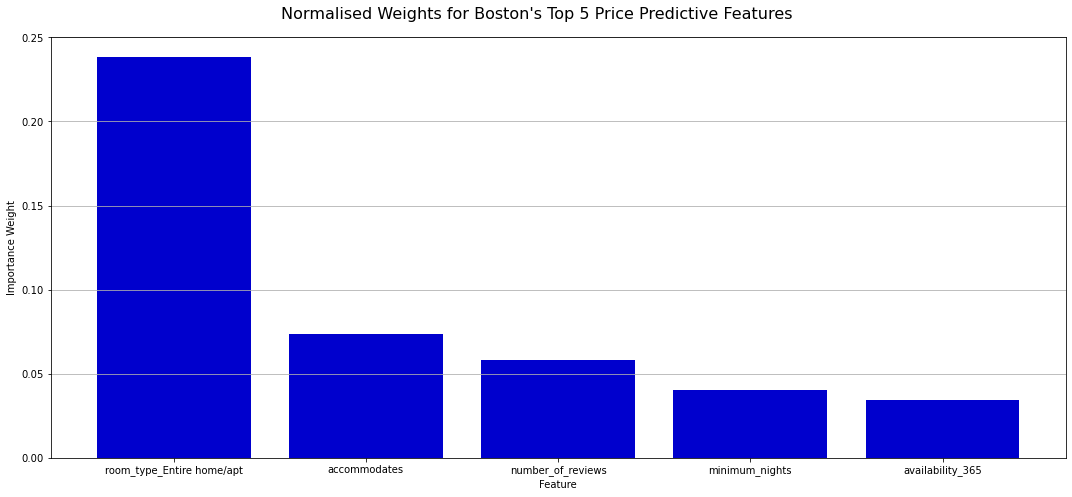

In [99]:
# Create a visualisation of 5 features with the highest importance when predicting listing price for both Boston and Oakland
# Let's look at Boston first
most_important_features_boston = feature_importance_boston[:5]

fig = plt.figure(figsize = (15, 7))
fig.suptitle('Normalised Weights for Boston\'s Top 5 Price Predictive Features', fontsize=16)
plt.bar(most_important_features_boston['feature'], most_important_features_boston['feature_importance'], align='center', color='mediumblue')
plt.xlabel("Feature")
plt.ylabel("Importance Weight")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

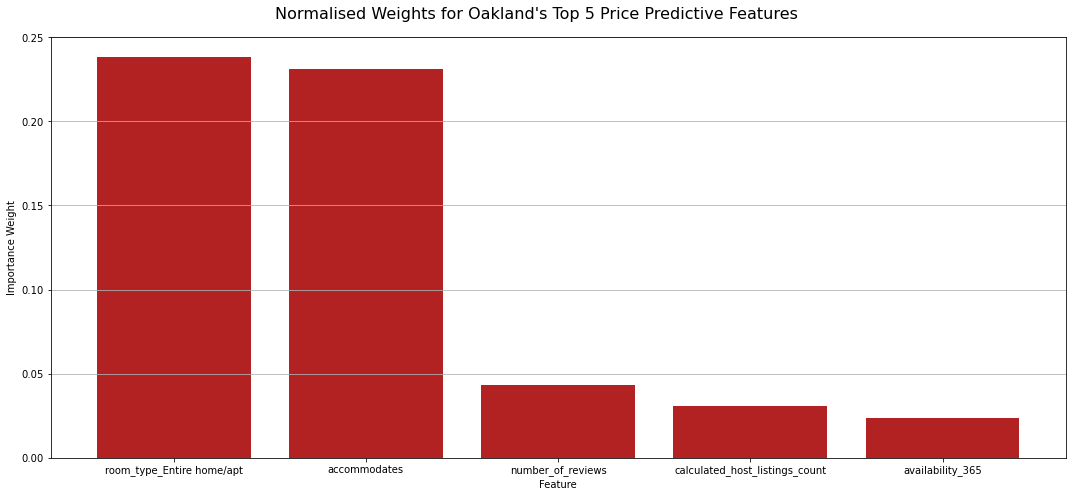

In [100]:
# Now let's look at Oakland
most_important_features_oakland = feature_importance_oakland[:5]

fig = plt.figure(figsize = (15, 7))
fig.suptitle('Normalised Weights for Oakland\'s Top 5 Price Predictive Features', fontsize=16)
plt.bar(most_important_features_oakland['feature'], most_important_features_oakland['feature_importance'], align='center', color='firebrick')
plt.xlabel("Feature")
plt.ylabel("Importance Weight")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

It is not surprising that fields such as room_type and accommodation capacity are highly predictive of listing price. Given that we are interested in which amenities have the largest influence on price, let's consider the largest 10 importances from these fields and how they compare between Boston and Oakland.

In [102]:
# Extract feature importances for top 5 amenities for Boston and Oakland
# Boston top 5 amenities
most_important_amenities_boston = feature_importance_boston[feature_importance_boston['feature'].isin(listings_boston_amenities_fields)]['feature'][:5].to_list()
feature_importance_boston[feature_importance_boston['feature'].isin(most_important_amenities_boston)]

feature  feature_importance
80  amenities_gym            0.015793
26       Elevator            0.011277
94   amenities_tv            0.010866
37        Kitchen            0.009168
67  amenities_bbq            0.009073

In [103]:
# Oakland top 5 amenities
most_important_amenities_oakland = feature_importance_oakland[feature_importance_oakland['feature'].isin(listings_oakland_amenities_fields)]['feature'][:5].to_list()
feature_importance_oakland[feature_importance_oakland['feature'].isin(most_important_amenities_oakland)]

feature  feature_importance
82               amenities_gym            0.019681
25                  Dishwasher            0.012324
65  amenities_air_conditioning            0.008035
79         amenities_fireplace            0.007680
70               amenities_bbq            0.006859

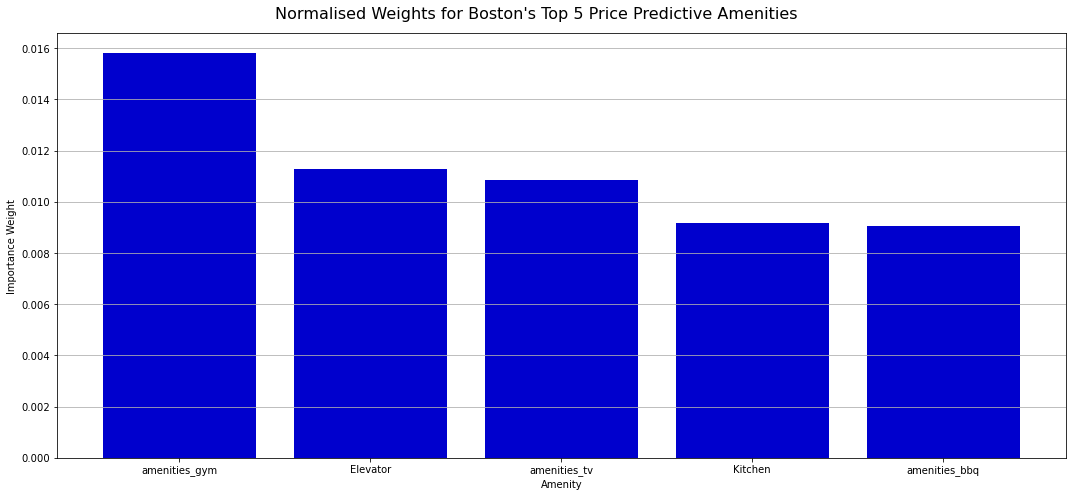

In [105]:
# Create a visualisation of the top 5 amenities with the highest importance when predicting listing price for both Boston and Oakland
# Boston
most_important_amenities_boston_plot = feature_importance_boston[feature_importance_boston['feature'].isin(most_important_amenities_boston)]

fig = plt.figure(figsize = (15, 7))
fig.suptitle('Normalised Weights for Boston\'s Top 5 Price Predictive Amenities', fontsize=16)
plt.bar(most_important_amenities_boston_plot['feature'], most_important_amenities_boston_plot['feature_importance'], align='center', color='mediumblue')
plt.xlabel("Amenity")
plt.ylabel("Importance Weight")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

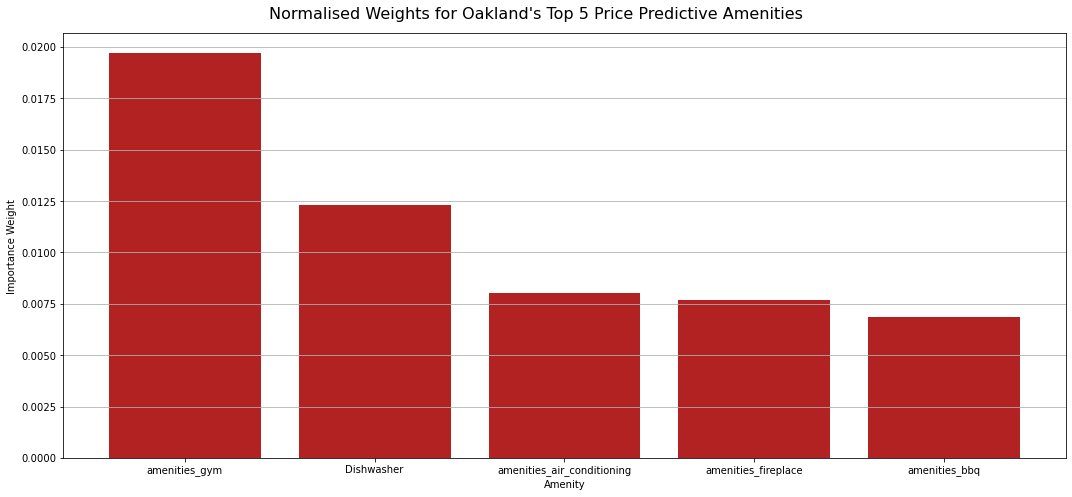

In [106]:
# Oakland
most_important_amenities_oakland_plot = feature_importance_oakland[feature_importance_oakland['feature'].isin(most_important_amenities_oakland)]

fig = plt.figure(figsize = (15, 7))
fig.suptitle('Normalised Weights for Oakland\'s Top 5 Price Predictive Amenities', fontsize=16)
plt.bar(most_important_amenities_oakland_plot['feature'], most_important_amenities_oakland_plot['feature_importance'], align='center', color='firebrick')
plt.xlabel("Amenity")
plt.ylabel("Importance Weight")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

For both Boston and Oakland it appears that having access to gym facilities in the property has the greatest influence on its listing price. This is closely followed by having a TV, elevator and BBQ in Boston, whereas in Oakland the next most influencial amenities in terms of price are having a BBQ, dishwasher and air conditioning.

**`6.` How many reviews do homes tend to get? What are common words used in reviews and are they primarily positive or negative? How does this compare between Boston and Oakland?**

Let's use the comments field from the reviews datasets to determine the average number of reviews for listings in Boston and Oakland. We will also use this data to identify common words used and whether or not listings in Boston and Oakland receive positive or negatively worded reviews.

First let's look at the distribution of number of reviews per listing in Boston and Oakland.

In [107]:
# Check for missing values in the comments field of the reviews datasets
print('Boston reviews dataset missing values\n')
print(reviews_boston.isnull().sum())
print('\n')
print('Oakland reviews dataset missing values\n')
print(reviews_oakland.isnull().sum())

Boston reviews dataset missing values

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     1
comments         74
dtype: int64


Oakland reviews dataset missing values

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         57
dtype: int64


In [108]:
# As the missing values only occur in the reviewer_name and comments fields clean the dataframes of any NaN values by replacing with empty strings
reviews_boston = reviews_boston.fillna('')
reviews_oakland = reviews_oakland.fillna('')

In [109]:
# How many reviews have been written for listings in Boston and Oakland
# What proportion of listings in Boston and Oakland have received at least 1 review
print('Boston total reviews:', reviews_boston.comments.count())
print('Boston proportion of listings with at least 1 review:', reviews_boston.groupby('listing_id').count().shape[0] / len(listings_boston))
print('Oakland total reviews:', reviews_oakland.comments.count())
print('Oakland proportion of listings with at least 1 review:', reviews_oakland.groupby('listing_id').count().shape[0] / len(listings_oakland))

Boston total reviews: 117541
Boston proportion of listings with at least 1 review: 0.7176432710882164
Oakland total reviews: 86819
Oakland proportion of listings with at least 1 review: 0.6910039113428944


In [110]:
# Determine the reviews per listing in Boston and Oakland

# Boston
reviews_boston_per_listing = reviews_boston.groupby('listing_id').count()['id'].to_list()
# Boston - private rooms
list_boston_room = listings_boston[listings_boston['room_type'] == 'Private room']['id'].to_list()
reviews_boston_room = reviews_boston[reviews_boston['listing_id'].isin(list_boston_room)]
reviews_boston_per_listing_room = reviews_boston_room.groupby('listing_id').count()['id'].to_list()
# Boston - entire home
list_boston_home = listings_boston[listings_boston['room_type'] == 'Entire home/apt']['id'].to_list()
reviews_boston_home = reviews_boston[reviews_boston['listing_id'].isin(list_boston_home)]
reviews_boston_per_listing_home = reviews_boston_home.groupby('listing_id').count()['id'].to_list()

# Oakland
reviews_oakland_per_listing = reviews_oakland.groupby('listing_id').count()['id'].to_list()
# Oakland - private rooms
list_oakland_room = listings_oakland[listings_oakland['room_type'] == 'Private room']['id'].to_list()
reviews_oakland_room = reviews_oakland[reviews_oakland['listing_id'].isin(list_oakland_room)]
reviews_oakland_per_listing_room = reviews_oakland_room.groupby('listing_id').count()['id'].to_list()
# Oakland - entire home
list_oakland_home = listings_oakland[listings_oakland['room_type'] == 'Entire home/apt']['id'].to_list()
reviews_oakland_home = reviews_oakland[reviews_oakland['listing_id'].isin(list_oakland_home)]
reviews_oakland_per_listing_home = reviews_oakland_home.groupby('listing_id').count()['id'].to_list()

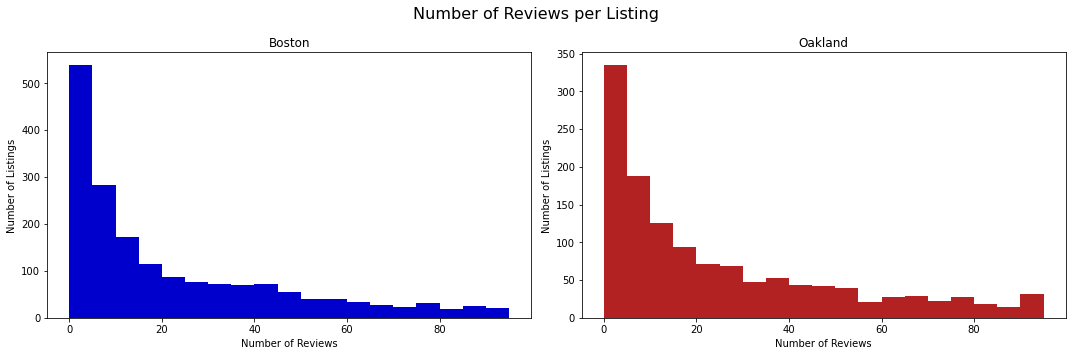

In [111]:
# Create a visualisation comparing number of reviews per listing in Boston and Oakland
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of Reviews per Listing', fontsize=16)

ax[0].hist(reviews_boston_per_listing, color="mediumblue", bins=np.arange(0,100,5));
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Number of Listings');
ax[0].set_xlabel('Number of Reviews');

ax[1].hist(reviews_oakland_per_listing, color="firebrick", bins=np.arange(0,100,5));
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Number of Listings');
ax[1].set_xlabel('Number of Reviews');

plt.tight_layout();

In [112]:
# Print statistics for reviews per listing in Boston and Oakland
print("Boston reviews per listing statistics\n")
print(pd.Series(reviews_boston_per_listing).describe())
print("\n")
print("Oakland reviews per listing statistics\n")
print(pd.Series(reviews_oakland_per_listing).describe())

Boston reviews per listing statistics

count    2229.000000
mean       52.732616
std        76.254813
min         1.000000
25%         5.000000
50%        20.000000
75%        68.000000
max       582.000000
dtype: float64


Oakland reviews per listing statistics

count    1590.000000
mean       54.603145
std        77.164461
min         1.000000
25%         6.000000
50%        23.000000
75%        71.000000
max       623.000000
dtype: float64


In Boston and Oakland approximately 70% of listings have received at least 1 review. The distribution of the number of reviews per listing also appears to be similar for both Boston and Oakland, with 55 reviews on average per listing and approximately 1/4 of the listings (that have been reviewed) only having 4 reviews or less. Let's see if the distributions differ when we only consider private room or entire home listings.

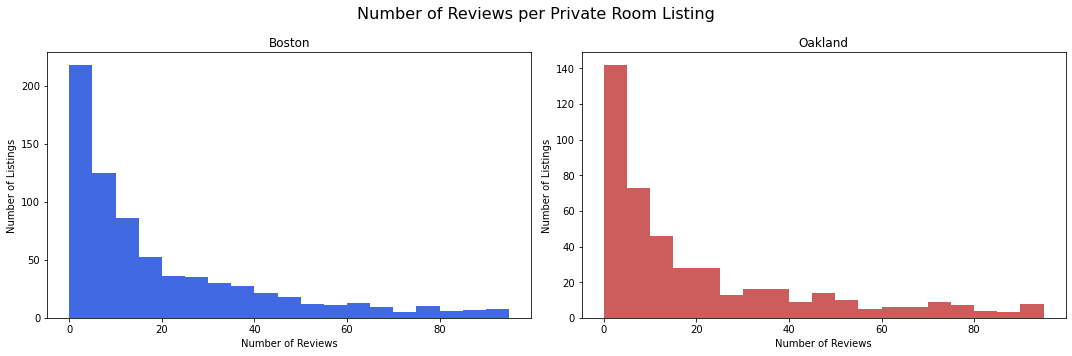

In [113]:
# Create a visualisation comparing number of reviews per private room listing in Boston and Oakland
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of Reviews per Private Room Listing', fontsize=16)

ax[0].hist(reviews_boston_per_listing_room, color="royalblue", bins=np.arange(0,100,5));
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Number of Listings');
ax[0].set_xlabel('Number of Reviews');

ax[1].hist(reviews_oakland_per_listing_room, color="indianred", bins=np.arange(0,100,5));
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Number of Listings');
ax[1].set_xlabel('Number of Reviews');

plt.tight_layout();

In [114]:
# Print statistics for reviews per private room listing in Boston and Oakland
print("Boston reviews per private room listing statistics\n")
print(pd.Series(reviews_boston_per_listing_room).describe())
print("\n")
print("Oakland reviews per private room listing statistics\n")
print(pd.Series(reviews_oakland_per_listing_room).describe())

Boston reviews per private room listing statistics

count    880.000000
mean      49.152273
std       77.932029
min        1.000000
25%        5.000000
50%       15.000000
75%       54.250000
max      551.000000
dtype: float64


Oakland reviews per private room listing statistics

count    514.000000
mean      42.933852
std       68.990320
min        1.000000
25%        4.000000
50%       14.000000
75%       49.750000
max      557.000000
dtype: float64


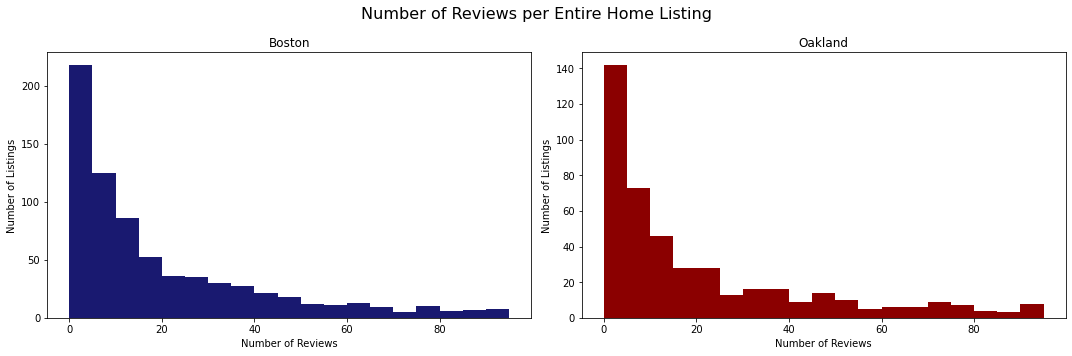

In [115]:
# Create a visualisation comparing number of reviews per private room listing in Boston and Oakland
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of Reviews per Entire Home Listing', fontsize=16)

ax[0].hist(reviews_boston_per_listing_room, color="midnightblue", bins=np.arange(0,100,5));
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Number of Listings');
ax[0].set_xlabel('Number of Reviews');

ax[1].hist(reviews_oakland_per_listing_room, color="darkred", bins=np.arange(0,100,5));
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Number of Listings');
ax[1].set_xlabel('Number of Reviews');

plt.tight_layout();

In [116]:
# Print statistics for reviews per entire home listing in Boston and Oakland
print("Boston reviews per entire home listing statistics\n")
print(pd.Series(reviews_boston_per_listing_home).describe())
print("\n")
print("Oakland reviews per entire home listing statistics\n")
print(pd.Series(reviews_oakland_per_listing_home).describe())

Boston reviews per entire home listing statistics

count    1324.000000
mean       55.599698
std        75.525370
min         1.000000
25%         5.000000
50%        24.000000
75%        77.000000
max       582.000000
dtype: float64


Oakland reviews per entire home listing statistics

count    997.000000
mean      62.877633
std       82.278393
min        1.000000
25%        8.000000
50%       30.000000
75%       86.000000
max      623.000000
dtype: float64


From the analysis above it appears that Boston receives more reviews per private room listing on average than Oakland, whereas, Oakland receives more reviews per entire home listing on average.

Next let's take a closer look at the wording in the reviews to see if there are any trends, similarities or differences from one review to the next or from Boston to Seattle.  We will need to do some cleaning again.

In [117]:
# Merge all review comments into a single string for each city
all_review_comments_boston = ', '.join(str(rev) for rev in list(reviews_boston['comments']))
all_review_comments_oakland = ', '.join(str(rev) for rev in list(reviews_oakland['comments']))

In [118]:
# Define a function to clean the reviews text data and count occurance
# Returns a list of tuples containing the review word and occurance count in ascending order
def clean_review_text(all_review_comments):
    
    # Create a list of stop words and remove from list of words
    stop_words = set(stopwords.words('english'))
    words = filter(lambda word: not word in stop_words, all_review_comments.lower().split())
    
    # Remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in words]
    
    # Count each occurance and sort list of words alphabetically
    word_count = Counter(stripped)
    sorted_word_count = sorted(word_count.items(), key=operator.itemgetter(1))
    
    return sorted_word_count

In [119]:
# Apply cleaning function to combined strings
sorted_review_words_boston = clean_review_text(all_review_comments_boston)
sorted_review_words_oakland = clean_review_text(all_review_comments_oakland)

In [120]:
# List of top 25 words used in reviews of Boston listings
boston_reviews_top_words = sorted(sorted_review_words_boston, key=operator.itemgetter(1), reverse=True)[:25]
boston_reviews_top_words

[('great', 67048),
 ('place', 58411),
 ('stay', 52296),
 ('location', 40090),
 ('boston', 39643),
 ('clean', 38558),
 ('', 37967),
 ('apartment', 26950),
 ('would', 26086),
 ('nice', 24313),
 ('host', 21792),
 ('comfortable', 20904),
 ('room', 20848),
 ('recommend', 18854),
 ('easy', 18554),
 ('us', 18530),
 ('everything', 17762),
 ('perfect', 15803),
 ('house', 15802),
 ('close', 15480),
 ('good', 15196),
 ('home', 15114),
 ('definitely', 14684),
 ('really', 14189),
 ('well', 13584)]

In [121]:
# List of top 25 words used in reviews of Oakland listings
oakland_reviews_top_words = sorted(sorted_review_words_oakland, key=operator.itemgetter(1), reverse=True)[:25]
oakland_reviews_top_words

[('place', 46925),
 ('great', 46389),
 ('stay', 42337),
 ('', 29305),
 ('clean', 24470),
 ('location', 19013),
 ('would', 18935),
 ('nice', 18906),
 ('comfortable', 18323),
 ('host', 17387),
 ('home', 15474),
 ('space', 14764),
 ('oakland', 14443),
 ('house', 14357),
 ('area', 14130),
 ('everything', 13463),
 ('us', 13395),
 ('recommend', 13199),
 ('easy', 12647),
 ('definitely', 11982),
 ('room', 11619),
 ('really', 11449),
 ('perfect', 11233),
 ('beautiful', 10832),
 ('neighborhood', 10813)]

In [122]:
# In order to compare, create a list of the top 100 words used in reviews of listings in Boston and Oakland
boston_reviews_100_words = []
for tup in sorted(sorted_review_words_boston, key=operator.itemgetter(1), reverse=True)[:100]:
    boston_reviews_100_words.append(tup[0])

oakland_reviews_100_words = []
for tup in sorted(sorted_review_words_oakland, key=operator.itemgetter(1), reverse=True)[:100]:
    oakland_reviews_100_words.append(tup[0])

In [123]:
# Create functions to determine the intersection and differences between the top 100 words used in reviews of listings in Boston and Oakland
def top_review_words_intersection(list_1, list_2): 
    list_3 = [word for word in list_1 if word in list_2] 
    return list_3

def top_review_words_difference(list_1, list_2):
    list_3 = [word for word in list_1 if word not in list_2] 
    return list_3

In [124]:
# What words are common between listing reviews in Boston and Oakland
common_reviews_words = top_review_words_intersection(boston_reviews_100_words, oakland_reviews_100_words)
common_reviews_words

['great',
 'place',
 'stay',
 'location',
 'clean',
 '',
 'apartment',
 'would',
 'nice',
 'host',
 'comfortable',
 'room',
 'recommend',
 'easy',
 'us',
 'everything',
 'perfect',
 'house',
 'close',
 'good',
 'home',
 'definitely',
 'really',
 'well',
 'space',
 'walk',
 'time',
 'again',
 'also',
 'neighborhood',
 'area',
 'super',
 'beautiful',
 'get',
 'quiet',
 'back',
 'restaurants',
 'highly',
 'wonderful',
 'bed',
 'one',
 'helpful',
 'like',
 'staying',
 'convenient',
 'walking',
 'amazing',
 'needed',
 'kitchen',
 'street',
 'made',
 'bathroom',
 'hosts',
 'lovely',
 'parking',
 'check',
 'need',
 'airbnb',
 'even',
 'experience',
 'quick',
 'around',
 'little',
 'could',
 'enjoyed',
 'located',
 'friendly',
 'night',
 'away',
 'loved',
 'spacious',
 'stayed',
 'much',
 'communication',
 'responsive',
 'cozy',
 'day',
 'amenities',
 'felt',
 'thanks',
 'feel',
 'coffee',
 'thank']

In [125]:
# What words are unique to Boston listing reviews when compared to Oakland listing reviews
boston_unique_reviews_words = top_review_words_difference(boston_reviews_100_words, oakland_reviews_100_words)
boston_unique_reviews_words

['boston',
 'city',
 'downtown',
 'distance',
 'station',
 'excellent',
 'right',
 'trip',
 'short',
 'next',
 'two',
 'minutes',
 'first',
 'airport',
 'de',
 'small',
 'many']

In [126]:
# What words are unique to Oakland listing reviews when compared to Boston listing reviews
oakland_unique_reviews_words = top_review_words_difference(oakland_reviews_100_words, boston_reviews_100_words)
oakland_unique_reviews_words

['oakland',
 'bart',
 'bay',
 'san',
 'francisco',
 'private',
 'safe',
 'spot',
 'family',
 'view',
 'welcoming',
 'studio',
 'best',
 'cute',
 'accommodating',
 'cottage',
 'make']

In order to more easily visualise the commonality and differences between the words used in reviews of listings in Boston and Oakland, let's create word clouds of the review words.

In [127]:
# Merge all reviews into one string and remove stop words and punctuation for Boston and Oakland

# Create a list of stop words and remove from list of words
stop_words = set(stopwords.words('english'))
words_reviews_boston = filter(lambda word: not word in stop_words, all_review_comments_boston.lower().split())
words_reviews_oakland = filter(lambda word: not word in stop_words, all_review_comments_oakland.lower().split())

# Remove punctuation from each word
table = str.maketrans('', '', string.punctuation)
stripped_boston = [word.translate(table) for word in words_reviews_boston]
stripped_oakland = [word.translate(table) for word in words_reviews_oakland]

boston_reviews_words_str = ' '.join(stripped_boston)
oakland_reviews_words_str = ' '.join(stripped_oakland)

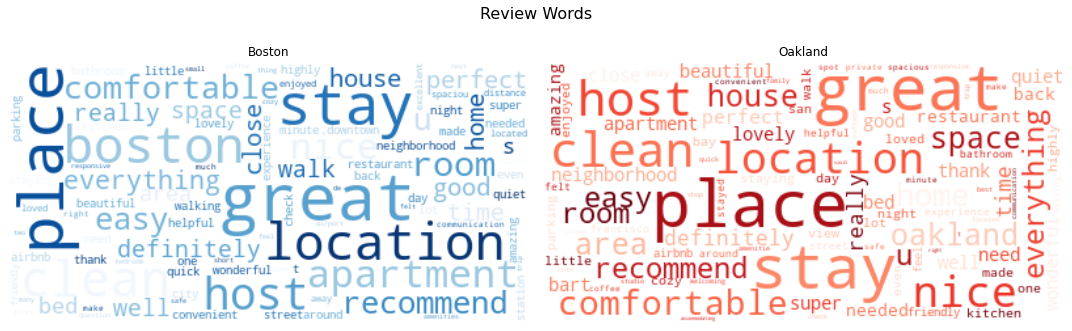

In [128]:
# Create word clouds for reviews of listings in Boston and Oakland
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Review Words', fontsize=16)

wordcloud_boston = WordCloud(max_font_size=50,
                             max_words=100,
                             background_color="white",
                             colormap='Blues',
                             collocations=False).generate(boston_reviews_words_str)

ax[0].imshow(wordcloud_boston, interpolation="bilinear");
ax[0].axis("off");
ax[0].title.set_text('Boston');

wordcloud_oakland = WordCloud(max_font_size=50,
                              max_words=100,
                              background_color="white",
                              colormap='Reds',
                              collocations=False).generate(oakland_reviews_words_str)

ax[1].imshow(wordcloud_oakland, interpolation="bilinear");
ax[1].axis("off");
ax[1].title.set_text('Oakland');

plt.tight_layout();

From the word clouds above we can see which words are common or unique to reviews for each city. For example both Boston and Oakland reviews regularly contain the words 'clean', 'comfortable' and 'quiet'. In terms of words that are unique to reviews for that city, reviews of Boston listings regularly feature the words 'station', 'airport' and 'small', whereas, reviews of Oakland listings feature the words 'safe', 'family' and 'welcoming' instead.

Next let's analyse at the sentiment of reviews (positive, negative or neutral) for listings in Boston and Oakland using TextBlob's polarity score.

In [129]:
# Calculate sentiment polarity for each review for both Boston and Oakland listings

# Boston
boston_review_sentiment_polarity = []
for i in range(0, reviews_boston.shape[0]):
    text = str(reviews_boston.comments[i])
    polarity = TextBlob(text).sentiment.polarity
    boston_review_sentiment_polarity.append(polarity)

# Oakland
oakland_review_sentiment_polarity = []
for i in range(0, reviews_oakland.shape[0]):
    text = str(reviews_oakland.comments[i])
    polarity = TextBlob(text).sentiment.polarity
    oakland_review_sentiment_polarity.append(polarity)

In [130]:
# Add polarity column
reviews_boston['polarity'] = boston_review_sentiment_polarity
reviews_oakland['polarity'] = oakland_review_sentiment_polarity

In [131]:
# Preview 5 reviews from Boston and Oakland with the highest positive sentiment polarity score
print('5 Boston listing reviews with the highest positive sentiment polarity: \n')
boston_positive_polarity_comments = reviews_boston.loc[reviews_boston.polarity == 1, ['comments']].sample(5).values
for comment in boston_positive_polarity_comments:
    print(comment[0])
print('\n')
print('5 Oakland listing reviews with the highest positive sentiment polarity: \n')
oakland_positive_polarity_comments = reviews_oakland.loc[reviews_oakland.polarity == 1, ['comments']].sample(5).values
for comment in oakland_positive_polarity_comments:
    print(comment[0])

5 Boston listing reviews with the highest positive sentiment polarity: 

Great place to stay!
Great stay!
Great spot to stay!!
Great experience!!
Brilliant place!


5 Oakland listing reviews with the highest positive sentiment polarity: 

Excellent location and amenities
Anna and Bill's place was perfect for my needs, and it was a pleasure to stay with them again
Excellent Place!
This was great stay!
Adi was a perfect host, would definitly stay again!


In [132]:
# Preview 5 reviews from Boston and Oakland with a neutral sentiment polarity score
print('5 Boston listing reviews with a neutral sentiment polarity: \n')
boston_neutral_polarity_comments = reviews_boston.loc[reviews_boston.polarity == 0, ['comments']].sample(5).values
for comment in boston_neutral_polarity_comments:
    print(comment[0])
print('\n')
print('5 Oakland listing reviews with a neutral sentiment polarity: \n')
oakland_neutral_polarity_comments = reviews_oakland.loc[reviews_oakland.polarity == 0, ['comments']].sample(5).values
for comment in oakland_neutral_polarity_comments:
    print(comment[0])

5 Boston listing reviews with a neutral sentiment polarity: 

The unit is well located in the heart of Beacon Hill. It needs some cosmetic work ( peeling paint and evidence of water leaks), and we initially had internet connection connectivity issues.  The office staff ( phone number provided) were helpful with that during business hours the next day.
This is a hotel, motel, holiday inn
Jacky had no control over this situation
시내와 매우 가깝고, 호스트가 매우 친절합니다.
-


5 Oakland listing reviews with a neutral sentiment polarity: 

Backyard escape was so relaxing
The host canceled this reservation 34 days before arrival. This is an automated posting.
Barrio oscuro y estacionamiento a dos cuadras.
The reservation was canceled the day before arrival. This is an automated posting.
Alojamiento bueno si es para dormir y pasar casi todo el dia fuera, el anfitrion muy atento a nuestra llegada.
Cada vez que vas a S.F hay que pasar un peaje obligatorio de 5$.


In [133]:
# Preview 5 reviews from Boston and Oakland with a negative sentiment polarity score
print('5 Boston listing reviews with a negative sentiment polarity: \n')
boston_negative_polarity_comments = reviews_boston.loc[reviews_boston.polarity == -1, ['comments']].sample(5).values
for comment in boston_negative_polarity_comments:
    print(comment[0])
print('\n')
print('5 Oakland listing reviews with a negative sentiment polarity: \n')
oakland_negative_polarity_comments = reviews_oakland.loc[reviews_oakland.polarity == -1, ['comments']].sample(5).values
for comment in oakland_negative_polarity_comments:
    print(comment[0])

5 Boston listing reviews with a negative sentiment polarity: 

Worst place ever
Terrible temperature for sleeping for all there days because of no heater
Worst ever never go there it’s literally a jail/holding cell .
Terrible
Ha sido un experiencia increíble. Muy muy buena. Tanto Fabs como Christy se han portado de 10 conmigo. Lo que más destacaría es que son dos grandísimas personas y me han ayudado en todo lo que he necesitado. 

La casa estaba perfecta. La habitación súper limpia y ordenada. También el aseo siempre limpio. La verdad es que he estado súper cómodo y he podido dormir como un bebé. 

Por otro lado, el barrio es brutal. Parece de película. Además es súper seguro caminar por la noche. Yo no he tenido ningún problema. 

En definitiva, si vais a Boston no dudéis en alojarse con éllos porque yo he estado como en mi casa. ¡Muchas gracias por todo Fabs y Christy!


5 Oakland listing reviews with a negative sentiment polarity: 

La caravane est trop sympa, c’est plus que confor

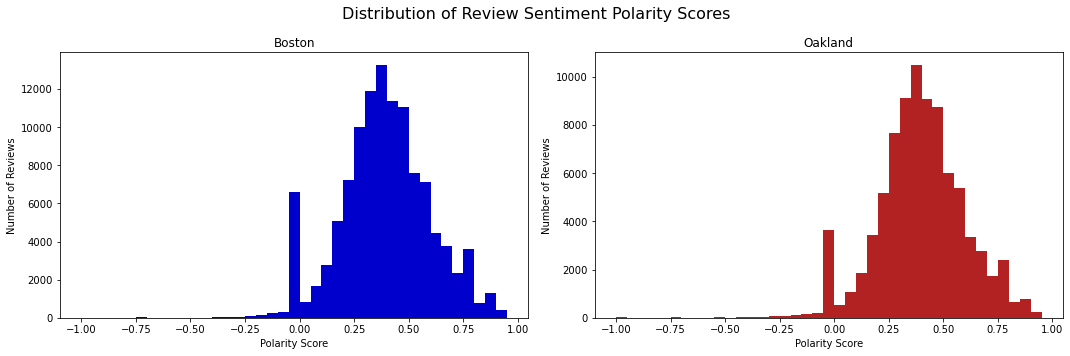

In [134]:
# Create visualisation of the distribution of review sentiment polarity scores for listings in Boston and Oakland
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Distribution of Review Sentiment Polarity Scores', fontsize=16)

ax[0].hist(boston_review_sentiment_polarity, color="mediumblue", bins=np.arange(-1,1,0.05));
ax[0].title.set_text('Boston');
ax[0].set_ylabel('Number of Reviews');
ax[0].set_xlabel('Polarity Score');

ax[1].hist(oakland_review_sentiment_polarity, color="firebrick", bins=np.arange(-1,1,0.05));
ax[1].title.set_text('Oakland');
ax[1].set_ylabel('Number of Reviews');
ax[1].set_xlabel('Polarity Score');

plt.tight_layout();

In [135]:
# Print statistics for sentiment polarity distributions for reviews of listings in Boston and Oakland
print("Boston reviews sentiment polarity statistics\n")
print(pd.Series(boston_review_sentiment_polarity).describe())
print("\n")
print("Oakland reviews sentiment polarity statistics\n")
print(pd.Series(oakland_review_sentiment_polarity).describe())

Boston reviews sentiment polarity statistics

count    117541.000000
mean          0.410000
std           0.230104
min          -1.000000
25%           0.273333
50%           0.398095
75%           0.533333
max           1.000000
dtype: float64


Oakland reviews sentiment polarity statistics

count    86819.000000
mean         0.414302
std          0.217623
min         -1.000000
25%          0.287500
50%          0.400000
75%          0.531250
max          1.000000
dtype: float64


The distribution of sentiment polarity scores for reviews of listings in Boston and Oakland are very similar. Nearly all listing reviews are greater than zero and have an average sentiment polarity score of 0.4, which means they are mostly positive.